In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
import squarify
import plotly.express as px
import matplotlib.ticker as ticker
from plotly.subplots import make_subplots
from matplotlib.pyplot import legend

from pandas_datareader import data as pdr
import investpy as ip
import yfinance as yf

%matplotlib inline
plt.style.use('seaborn') 

# ทำความเข้าใจตลาด EV ในอดีตและปัจจุบัน

In [2]:
df = pd.read_csv('EV\IEA-EV-data.csv')

# แยกตารางออกเป็น 3 ตาราง โดยแบ่งตาม category column
df_hist = df[df.category == 'Historical']
df_proj_steps = df[df.category == 'Projection-STEPS']
df_proj_aps = df[df.category == 'Projection-APS']

In [3]:
# filter ออกมาเฉพาะยอดขาย EV Car เท่านั้น

df_hist_EVCarSales = df_hist[(df_hist.parameter == 'EV sales') & (df_hist['mode'] == 'Cars')].pivot_table(
    index=['region', 'powertrain'], columns='year', values='value').round(2).reset_index()

df_hist_EVCarSales.head()

year,region,powertrain,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Australia,BEV,NaN,49.0,173.0,191.0,371.0,759.0,668.0,1208.0,1803.0,6283.0,5238.0,17300.0
1,Australia,PHEV,NaN,NaN,80.0,102.0,951.0,1012.0,701.0,1076.0,1802.0,2877.0,1700.0,3400.0
2,Belgium,BEV,35.0,281.0,1007.0,613.0,1448.0,1685.0,2292.0,3040.0,4168.0,8947.0,15071.0,22229.0
3,Belgium,PHEV,NaN,16.0,263.0,60.0,652.0,2170.0,7124.0,11651.0,9440.0,8830.0,33005.0,48451.0
4,Brazil,BEV,NaN,NaN,73.6,133.6,61.0,59.0,126.0,28.0,71.0,538.0,683.0,2041.0


Insert Column continent / ทวีป เพิ่มเติม

In [4]:
# !pip install a-world-of-countries

# Import the AWOC package.
import awoc
# Initialize the AWOC class.
my_world = awoc.AWOC()

# แก้ไขบางประเทศที่ชื่อมีปัญหา (ไม่เหมือนใน Library)
df_hist_EVCarSales.replace('Korea', 'South Korea', inplace=True)
df_hist_EVCarSales.replace('USA', 'United States', inplace=True)

# เพิ่มข้อมูลทวีปยกเว้น row ที่เขียนว่า Europe, Other Europe, World
df_hist_EVCarSales['continent'] = df_hist_EVCarSales[(df_hist_EVCarSales.region != 'Europe') & (df_hist_EVCarSales.region != 'Other Europe') & (df_hist_EVCarSales.region != 'World')]['region'].apply(lambda x: my_world.get_country_continent_name(x))

# กลับมาทำ Other Europe ต่อ โดยใส่ข้อมูลลงไปเองว่าคือ Europe
df_hist_EVCarSales.loc[df_hist_EVCarSales.region == 'Other Europe', 'continent'] = 'Europe'

df_hist_EVCarSales.tail()


year,region,powertrain,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,continent
55,United States,PHEV,NaN,7980.00,38590.0,49010.0,55360.00,42825.0,72885.00,93862.00,122492.00,84732.0,64311.0,164824.0,North America
56,United Kingdom,BEV,255.0,1211.00,1705.0,2679.0,6812.00,10095.0,10509.00,13550.60,15743.06,37972.0,107575.0,192107.0,Europe
57,United Kingdom,PHEV,21.0,7.00,988.0,1073.0,7931.00,19241.0,27403.00,33701.00,34619.00,36630.0,67461.0,120169.0,Europe
58,World,BEV,7361.0,40161.00,59160.6,113364.6,193677.33,328733.0,465670.12,759473.12,1371906.00,1545057.0,2015333.0,4651074.0,NaN
59,World,PHEV,382.0,9062.16,60726.4,91649.4,134365.20,223258.0,288004.88,417137.16,642786.00,578290.0,977954.0,1920575.0,NaN


Let's check Database : ถ้า Sum row ทั้งหมดยกเว้น World จะได้ผลลัพธ์เท่ากันไหม?

In [5]:
df_sum_EVCarSales = pd.DataFrame(
    df_hist_EVCarSales.loc[df_hist_EVCarSales.region != 'World'].iloc[:, 2:-1].sum().reset_index())
df_sum_EVCarSales.rename(columns={0: 'sum_except_world'}, inplace=True)

df_sum_EVCarSales['world'] = df_hist_EVCarSales.loc[df_hist_EVCarSales.region == 'World'].iloc[:, 2:-1].sum().values
df_sum_EVCarSales['Diff'] = df_sum_EVCarSales.sum_except_world - df_sum_EVCarSales.world
df_sum_EVCarSales['%Diff'] = ((df_sum_EVCarSales.sum_except_world - df_sum_EVCarSales.world) / df_sum_EVCarSales.world * 100).round(2)
display(df_sum_EVCarSales)

print(f"Sum of EV Sales except world differs from world row data by {-df_sum_EVCarSales['%Diff'].max()}% - {-df_sum_EVCarSales['%Diff'].min()}%")
# Why different?



,year,sum_except_world,world,Diff,%Diff
0,2010,7742.00,7743.00,-1.00,-0.01
1,2011,49169.16,49223.16,-54.00,-0.11
2,2012,118923.00,119887.00,-964.00,-0.80
3,2013,204373.00,205014.00,-641.00,-0.31
4,2014,327315.53,328042.53,-727.00,-0.22
5,2015,547270.00,551991.00,-4721.00,-0.86
6,2016,751464.00,753675.00,-2211.00,-0.29
7,2017,1165602.30,1176610.28,-11007.98,-0.94
8,2018,1990084.06,2014692.00,-24607.94,-1.22
9,2019,2100100.00,2123347.00,-23247.00,-1.09


Sum of EV Sales except world differs from world row data by 0.01% - 1.22%


Cal World ใหม่ โดยใช้ตัวเลข SUM ของแต่ละประเทศ (แยกตาราง BEV PHEV เผื่อใช้ในอนาคต)

- BEV

In [6]:
sumbev = df_hist_EVCarSales.loc[(df_hist_EVCarSales.region != 'World') & (df_hist_EVCarSales.powertrain == 'BEV')].iloc[:, 2:-1].sum().values
df_hist_EVCarSales.iloc[58, 2:-1] = sumbev

df_hist_EVCarSales.loc[(df_hist_EVCarSales.region == 'World') & (df_hist_EVCarSales.powertrain == 'BEV')]


year,region,powertrain,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,continent
58,World,BEV,7360.0,40107.0,58264.6,112744.6,193418.33,324939.0,464199.11,757392.15,1369228.06,1539656.0,2005851.0,4626444.0,NaN


- PHEV

In [7]:
sumphev = df_hist_EVCarSales.loc[(df_hist_EVCarSales.region != 'World') & (df_hist_EVCarSales.powertrain == 'PHEV')].iloc[:, 2:-1].sum().values
df_hist_EVCarSales.iloc[-1, 2:-1] = sumphev

df_hist_EVCarSales.loc[(df_hist_EVCarSales.region == 'World') & (df_hist_EVCarSales.powertrain == 'PHEV')]


year,region,powertrain,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,continent
59,World,PHEV,382.0,9062.16,60658.4,91628.4,133897.2,222331.0,287264.89,408210.15,620856.0,560444.0,961691.0,1899551.0,NaN


# ตาราง EV Sales หลังแก้ไขค่า
- Total EV Sales
- BEV Sales
- PHEV Sales

In [8]:
# Original
df_hist_EVCarSales.tail()

year,region,powertrain,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,continent
55,United States,PHEV,NaN,7980.00,38590.0,49010.0,55360.00,42825.0,72885.00,93862.00,122492.00,84732.0,64311.0,164824.0,North America
56,United Kingdom,BEV,255.0,1211.00,1705.0,2679.0,6812.00,10095.0,10509.00,13550.60,15743.06,37972.0,107575.0,192107.0,Europe
57,United Kingdom,PHEV,21.0,7.00,988.0,1073.0,7931.00,19241.0,27403.00,33701.00,34619.00,36630.0,67461.0,120169.0,Europe
58,World,BEV,7360.0,40107.00,58264.6,112744.6,193418.33,324939.0,464199.11,757392.15,1369228.06,1539656.0,2005851.0,4626444.0,NaN
59,World,PHEV,382.0,9062.16,60658.4,91628.4,133897.20,222331.0,287264.89,408210.15,620856.00,560444.0,961691.0,1899551.0,NaN


In [9]:
# Total EV Sales
total_evsales = df_hist_EVCarSales.groupby('region').sum().reset_index()
total_evsales.tail()

year,region,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
25,Sweden,4.0,178.00,928.0,1547.0,4667.00,8587.0,13415.0,20345.0,28958.00,40702.0,94231.0,136081.0
26,Switzerland,137.0,436.00,737.0,1323.0,2892.00,5626.0,6124.0,8423.0,9497.00,17474.0,33696.0,53489.0
27,United Kingdom,276.0,1218.00,2693.0,3752.0,14743.00,29336.0,37912.0,47251.6,50362.06,74602.0,175036.0,312276.0
28,United States,1191.0,17730.00,53240.0,96700.0,118780.00,113869.0,159616.0,198349.0,361315.00,326644.0,295399.0,631152.0
29,World,7742.0,49169.16,118923.0,204373.0,327315.53,547270.0,751464.0,1165602.3,1990084.06,2100100.0,2967542.0,6525995.0


In [10]:
# BEV Sales
bev_evsales = df_hist_EVCarSales.loc[df_hist_EVCarSales.powertrain == 'BEV']
bev_evsales.tail()

year,region,powertrain,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,continent
50,Sweden,BEV,4.0,178.0,266.0,432.0,1239.00,2962.0,2951.30,4359.00,7147.00,15795.0,28097.0,57881.0,Europe
52,Switzerland,BEV,137.0,395.0,342.0,1156.0,2688.00,3257.0,3295.00,4775.00,5138.00,13190.0,19311.0,31676.0,Europe
54,United States,BEV,1191.0,9750.0,14650.0,47690.0,63420.00,71044.0,86731.00,104487.00,238823.00,241912.0,231088.0,466328.0,North America
56,United Kingdom,BEV,255.0,1211.0,1705.0,2679.0,6812.00,10095.0,10509.00,13550.60,15743.06,37972.0,107575.0,192107.0,Europe
58,World,BEV,7360.0,40107.0,58264.6,112744.6,193418.33,324939.0,464199.11,757392.15,1369228.06,1539656.0,2005851.0,4626444.0,NaN


In [11]:
# PHEV Sales
phev_evsales = df_hist_EVCarSales.loc[df_hist_EVCarSales.powertrain == 'PHEV']
phev_evsales.tail()

year,region,powertrain,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,continent
51,Sweden,PHEV,NaN,NaN,662.0,1115.0,3428.0,5625.0,10463.70,15986.00,21811.0,24907.0,66134.0,78200.0,Europe
53,Switzerland,PHEV,NaN,41.00,395.0,167.0,204.0,2369.0,2829.00,3648.00,4359.0,4284.0,14385.0,21813.0,Europe
55,United States,PHEV,NaN,7980.00,38590.0,49010.0,55360.0,42825.0,72885.00,93862.00,122492.0,84732.0,64311.0,164824.0,North America
57,United Kingdom,PHEV,21.0,7.00,988.0,1073.0,7931.0,19241.0,27403.00,33701.00,34619.0,36630.0,67461.0,120169.0,Europe
59,World,PHEV,382.0,9062.16,60658.4,91628.4,133897.2,222331.0,287264.89,408210.15,620856.0,560444.0,961691.0,1899551.0,NaN


# visualize 

c:\Users\SSORAWIT\anaconda3\envs\dads4002\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


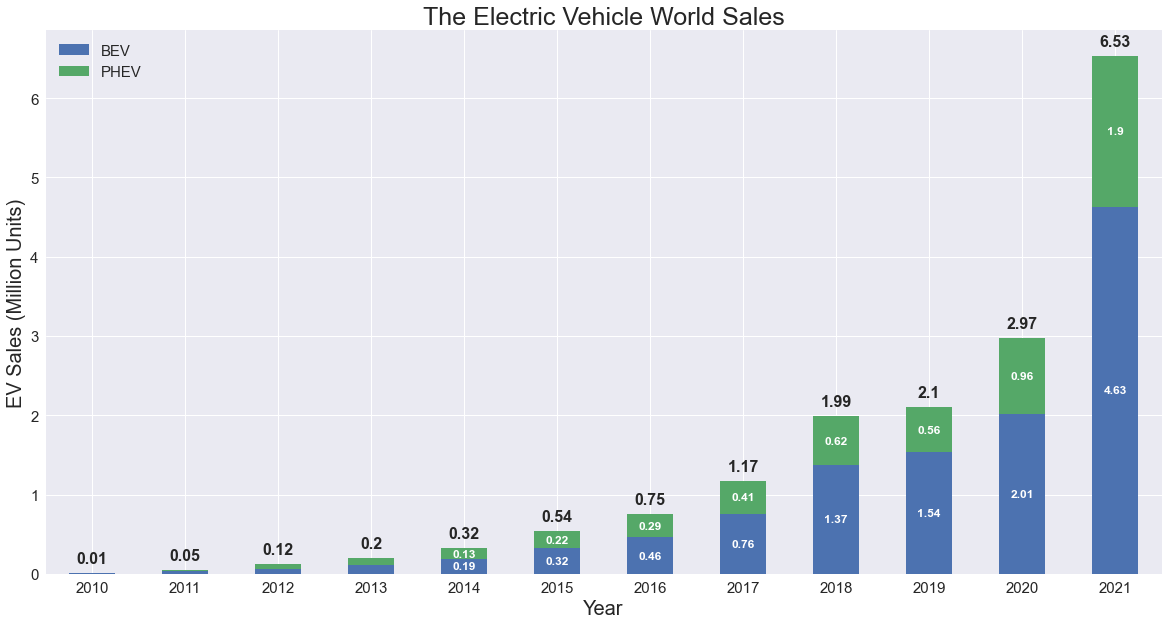

In [12]:
# World EV Car Sale

WorldEv = df_hist_EVCarSales.loc[df_hist_EVCarSales.region == 'World'].iloc[:,1:-1]
Plot_WorldEV = df_hist_EVCarSales.loc[df_hist_EVCarSales.region == 'World'].iloc[:,1:-1].transpose().reset_index().drop(0).rename(columns={58:'BEV', 59:'PHEV'})

Plot_WorldEV['BEV'] = Plot_WorldEV['BEV'].astype('float').round(2)
Plot_WorldEV['PHEV'] = Plot_WorldEV['PHEV'].astype('float').round(2)

for col in Plot_WorldEV.columns:
    if Plot_WorldEV[col].dtype == 'float64':
        Plot_WorldEV[col] = Plot_WorldEV[col]/1000000
        Plot_WorldEV[col] = Plot_WorldEV[col].round(2)


# Plot_WorldEV
ax = Plot_WorldEV.set_index('year').plot(kind='bar', stacked=True, figsize=(20, 10))

# add overall title
plt.title('The Electric Vehicle World Sales', fontsize=25)
# add axis titles
plt.xlabel('Year', fontsize=20)
plt.ylabel('EV Sales (Million Units)', fontsize=20)
# Rotate x-axis labels
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
# add legend size
plt.legend(fontsize='15')

for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0.11 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=12, color='white', fontweight='bold')

for x, y in enumerate(Plot_WorldEV.iloc[:,1:3].sum(axis=1).round(2)):
    ax.annotate(y, (x, y), ha='center', fontsize=16, fontweight='bold',  xytext=(0, 10), textcoords='offset points')


* Find CAGR

In [13]:
cagr_df = df_hist_EVCarSales.loc[df_hist_EVCarSales.region == 'World'].sum().reset_index()
# remove row0,1
cagr_df = cagr_df.iloc[2:-1].rename(columns={0: 'sum'})

start = cagr_df[cagr_df.year == 2010]['sum'].values[0]
end = cagr_df[cagr_df.year == 2021]['sum'].values[0]
periods = 12
    
def CAGR(start, end, periods):
    return (end/start)**(1/periods)-1

print ('CAGR: {:.2%} '.format(CAGR(start, end, periods)))


CAGR: 75.31% 


c:\Users\SSORAWIT\anaconda3\envs\dads4002\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


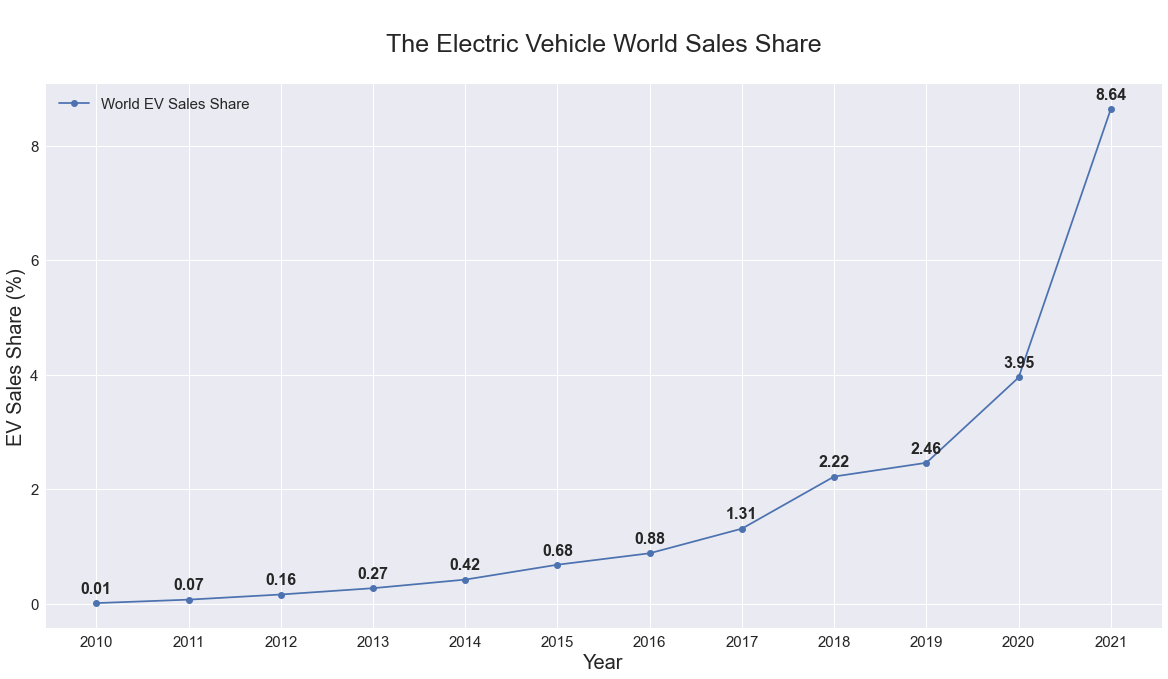

In [14]:
# World EV Car Share

df_hist_EVCarShare = df_hist[(df_hist.parameter == 'EV sales share') & (df_hist['mode'] == 'Cars')].pivot_table(
    index=['region', 'powertrain'], columns='year', values='value').round(2).reset_index()

World_EVShare = df_hist_EVCarShare[df_hist_EVCarShare.region == 'World'].iloc[:,1:].transpose().reset_index().drop(0).rename(columns={30:'World EV Sales Share'})
World_EVShare['year'].astype('int').tolist()

# Plot World EV Share
ax = World_EVShare.set_index('year').plot(kind='line', figsize=(20, 10), marker='o')

# add overall title
plt.title('\nThe Electric Vehicle World Sales Share', fontsize=25, y=1.05)

# add axis titles
plt.xlabel('Year', fontsize=20)
plt.ylabel('EV Sales Share (%)', fontsize=20)

# Rotate x-axis labels
plt.xticks(World_EVShare['year'].astype('int').tolist(), rotation=0, fontsize=15)

plt.yticks(fontsize=15)

# add legend size
plt.legend(fontsize='15')

for x,y in zip(World_EVShare.year, World_EVShare['World EV Sales Share']):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), ha='center', fontsize=16, fontweight='bold',  xytext=(0, 10), textcoords='offset points')

c:\Users\SSORAWIT\anaconda3\envs\dads4002\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


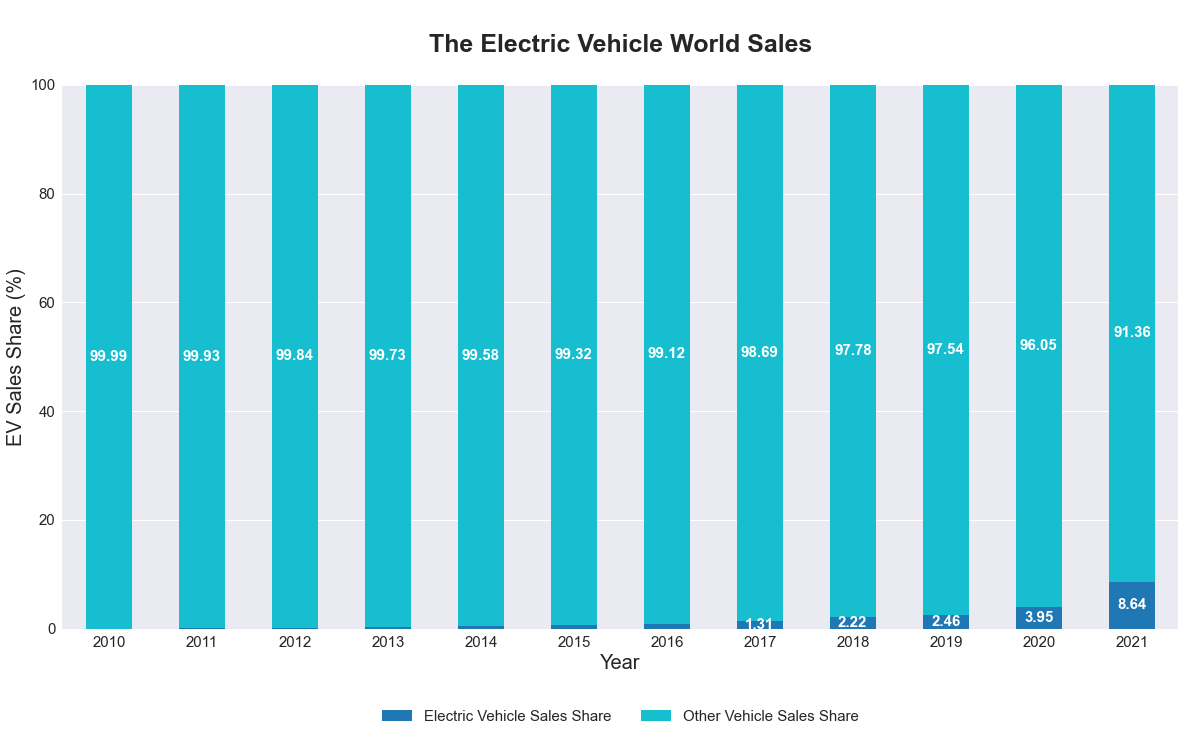

In [15]:
# Vehicle Powertrains Sales Share
# Create EV Sale Shares & Other Sales Shares
Vehicle_Powertrains_Sales_Share = World_EVShare.copy().rename(columns={'World EV Sales Share':'Electric Vehicle Sales Share'})
Vehicle_Powertrains_Sales_Share['Other Vehicle Sales Share'] = 100 - Vehicle_Powertrains_Sales_Share['Electric Vehicle Sales Share']

Vehicle_Powertrains_Sales_Share = Vehicle_Powertrains_Sales_Share.astype({'Electric Vehicle Sales Share': 'float64', 'Other Vehicle Sales Share': 'float64'})

ax = Vehicle_Powertrains_Sales_Share.set_index('year').plot(kind = 'bar', stacked=True, colormap='tab10', figsize=(20, 10))
# add overall title
plt.title('\nThe Electric Vehicle World Sales', fontsize=25, fontweight='bold', y=1.05)

# add axis titles
plt.xlabel('Year', fontsize=20)
plt.ylabel('EV Sales Share (%)', fontsize=20)

# otate x-axis labels
plt.xticks(rotation=0, fontsize=15)

plt.yticks(fontsize=15)
ax.set_ylim(0,100)

# add legend size
plt.legend(bbox_to_anchor=(0.5, -0.2), loc = 'lower center', fontsize='15', ncol = 2)

for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 1 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=15, fontweight='bold', color='white')

* ยอดขายรถ EV (รวมรถ BEV และรถ PHEV) มีการเติบโตอย่างมากโดยเร่งตัวถึง 75.31% CAGR จากจำนวนเพียงไม่กี่พันคันในปี 2010 มาอยู่ที่ 6.53 ล้านคันในปี 2021 
* โดยการเติบโตที่เร่งตัวนี้ทำให้สัดส่วนรถ EV ต่อยอดขายยานยนต์รวมต่อปีเพิ่มขึ้นมาอยู่ที่ 8.64% ในปี 2021
* ซึ่งถึงแม้จะว่าที่ผ่านมายอดขายรถและ Market Share ของ EV Cars จะเร่งตัวในอัตราที่สูงมาก แต่หากพิจารณากันจริงๆ แล้ว ยังพบว่ามีโอกาส หรือ Room ที่ให้ EV Car สามารถเติบโตและแย่งส่วนแบ่งการตลาดรถยนต์ประเภทอื่นๆ ได้อีกมาก



# ยอดขายรถ EV แบ่งตามภูมิภาค

c:\Users\SSORAWIT\anaconda3\envs\dads4002\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


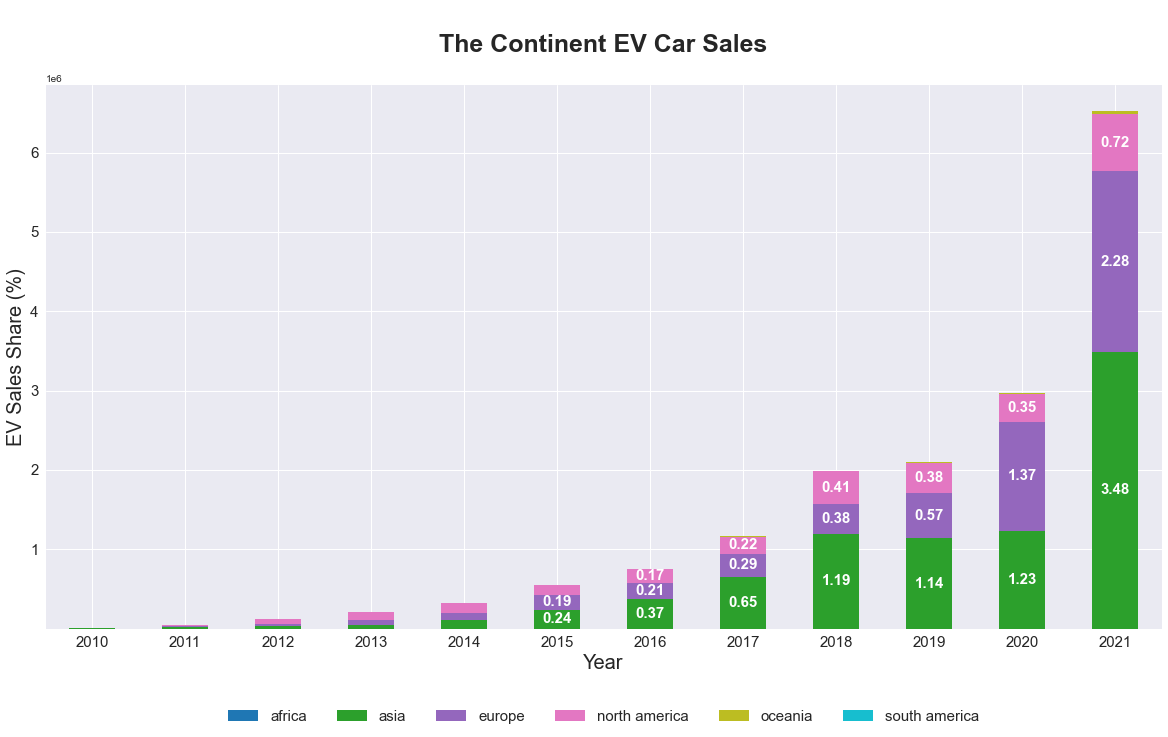

In [16]:
df_hist_EVCarSales_ExWorld = df_hist_EVCarSales[df_hist_EVCarSales['region'] != 'World']
df_sum_evsales_exworld = df_hist_EVCarSales_ExWorld.groupby('region').sum().reset_index()

df_hist_cont_evcarsales = df_hist_EVCarSales_ExWorld.groupby('continent').sum().reset_index()
df_hist_cont_evcarsales = df_hist_cont_evcarsales.transpose().reset_index().drop(0).rename(columns={0:'africa', 1:'asia', 2:'europe', 3:'north america', 4:'oceania', 5:'south america'})

# Plot
ax = df_hist_cont_evcarsales.set_index('year').plot(kind = 'bar', stacked=True, colormap='tab10', figsize=(20, 10))

# add overall title
plt.title('\nThe Continent EV Car Sales', fontsize=25, fontweight='bold', y=1.05)
# add axis titles
plt.xlabel('Year', fontsize=20)
plt.ylabel('EV Sales Share (%)', fontsize=20)
# otate x-axis labels
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
# add legend size
plt.legend(bbox_to_anchor=(0.5, -0.2), loc = 'lower center', fontsize='15', ncol = 6)

for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [(v.get_height()/1000000).round(2) if (v.get_height()/1000000).round(2) > 0.15 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fontsize=15, fontweight='bold', color='white')

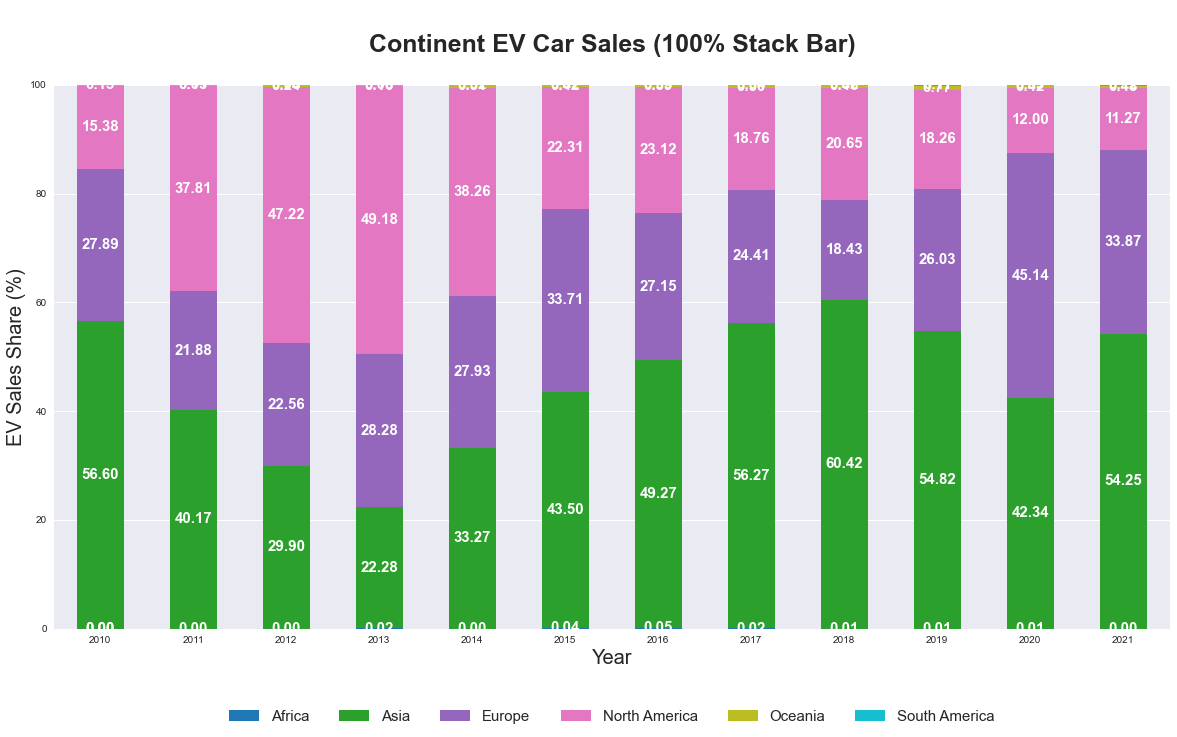

In [17]:
df_carsale2 = df_hist[(df_hist.parameter == 'EV sales') & (df_hist['mode'] == 'Cars')][['region', 'year', 'value']].groupby(['region', 'year']).sum().reset_index()
df_carsale2.replace('Korea', 'South Korea', inplace=True)
df_carsale2.replace('USA', 'United States', inplace=True)

df_carsale2['continent'] = df_carsale2[(df_carsale2.region != 'Europe') & (df_carsale2.region != 'Other Europe') & (df_carsale2.region != 'World')]['region'].apply(lambda x: my_world.get_country_continent_name(x))
df_carsale2[df_carsale2.region == 'Other Europe']
df_carsale2.loc[df_carsale2.region == 'Other Europe', 'continent']

df_ecsales_cont = df_carsale2.groupby(['continent','year']).sum().reset_index()
df_ecsales_cont[df_ecsales_cont['continent']=='South America']

testt = df_ecsales_cont.pivot_table(index='year', columns='continent', values='value').round(2)
percent_testt = testt.div(testt.sum(axis=1), axis=0)*100
percent_testt['sum'] = percent_testt.sum(axis=1)

# Plot
ax = percent_testt.loc[:, percent_testt.columns != 'sum'].plot(kind = 'bar', stacked=True, colormap='tab10', figsize=(20, 10))

ax.axes.set_title('\nContinent EV Car Sales (100% Stack Bar)', fontsize=25, fontweight='bold', y=1.05)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('EV Sales Share (%)', fontsize=20)
ax.tick_params(axis='x', rotation=0)
ax.set_ylim(0,100)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc = 'lower center', fontsize='15', ncol = 6)
sns.set(font_scale=1.3)

for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 1 else '' for v in c]
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, label_type='center', fontsize=15, fontweight='bold', color='white', fmt='%.2f')


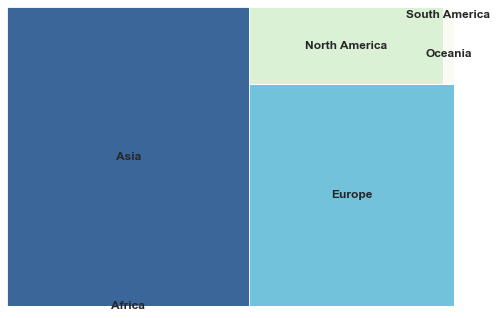

In [18]:
sns.set_style(style="whitegrid")

# colors = sns.color_palette("Spectral")

# create a color palette, mapped to these values
cmap = matplotlib.cm.GnBu
mini=min(percent_testt.iloc[-1:,:-1].reset_index().melt(id_vars='year')['value'].values)
maxi=max(percent_testt.iloc[-1:,:-1].reset_index().melt(id_vars='year')['value'].values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in (percent_testt.iloc[-1:,:-1].reset_index().melt(id_vars='year')['value'].values)]


ax = squarify.plot(sizes=(percent_testt.iloc[-1:,:-1].reset_index().melt(id_vars='year')['value']),
label=(percent_testt.iloc[-1:,:-1].reset_index().melt(id_vars='year')['continent']),
alpha=.8, color=colors,text_kwargs={'fontsize':12, 'fontweight':'bold'})
plt.axis('off')
plt.show()

## EV Car Sale & Sale Growth : Breakdown รายประเทศ

* 5-year average EV car sales by country

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/1243599370.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg_evsales_exworld['2010-2021Avg'] = df_sum_evsales_exworld.mean(axis=1).round(2)


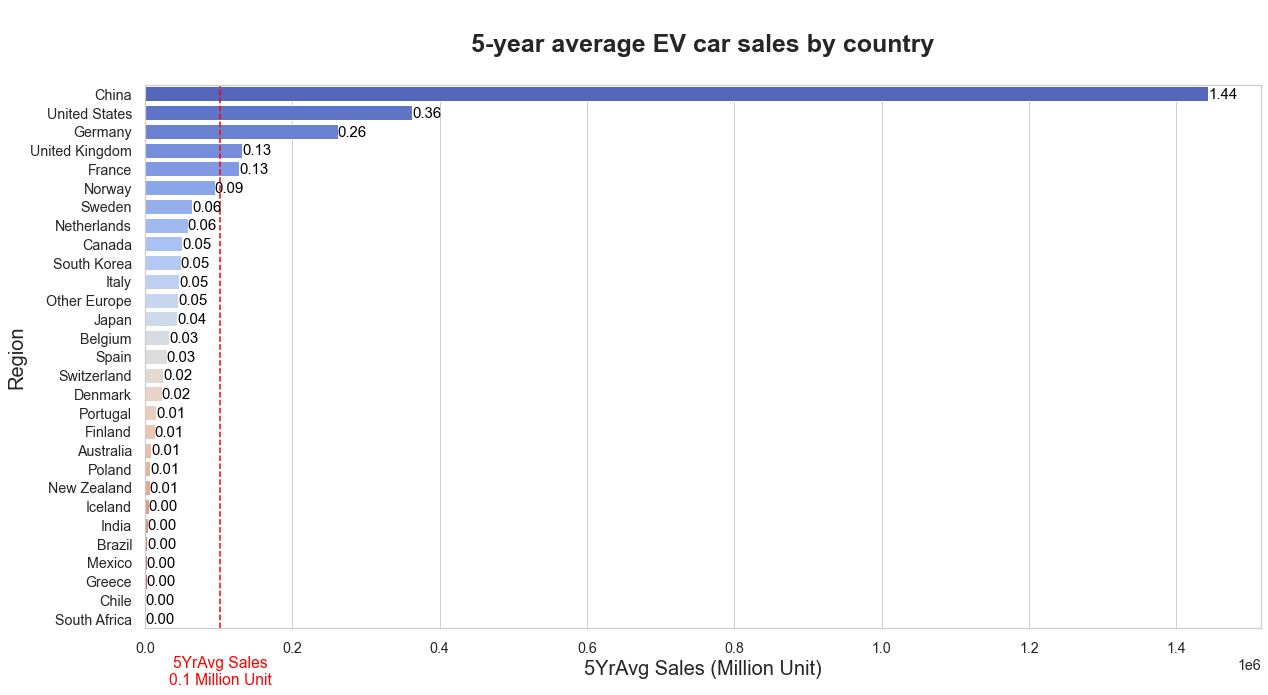

In [19]:
df_avg_evsales_exworld = pd.DataFrame()
df_avg_evsales_exworld['region'] = df_sum_evsales_exworld.region
df_avg_evsales_exworld['5YrAvg'] = df_sum_evsales_exworld.iloc[:, -5:].mean(axis=1).round(2)
df_avg_evsales_exworld['10YrAvg'] = df_sum_evsales_exworld.iloc[:, -10:].mean(axis=1).round(2)
df_avg_evsales_exworld['2010-2021Avg'] = df_sum_evsales_exworld.mean(axis=1).round(2)

# plot
fig, ax = plt.subplots(figsize=(20, 10))

plott = sns.barplot(x=df_avg_evsales_exworld['5YrAvg'],
y=df_avg_evsales_exworld['region'],
order=df_avg_evsales_exworld.sort_values(by='5YrAvg', ascending=False)['region'],
palette='coolwarm')

plott.axes.set_title('\n5-year average EV car sales by country', fontsize=25, fontweight='bold', y=1.05)
plott.set_ylabel('Region', fontsize=20)
plott.set_xlabel('5YrAvg Sales (Million Unit)', fontsize=20)
sns.set(font_scale = 1.3)

val = df_avg_evsales_exworld['5YrAvg'].mean().astype(int)
plott.axvline(val, color='red', linestyle='--')
plott.text(val,-.05, f'5YrAvg Sales\n{(val/1000000).round(2)} Million Unit',
color='red', transform=plott.get_xaxis_transform(), ha='center', va='top')

# show bar values if value > 1
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate(f'{p.get_width()/1000000:.2f}', (p.get_width(), p.get_y()+0.55*p.get_height()),
        ha='left', va='center', color='black', size=15, fontweight='light')

* Region Average 5 Years EV Car Sale Growth(%)

Text(58.6, 0.06, '5YrAvg Growth = 58.6')

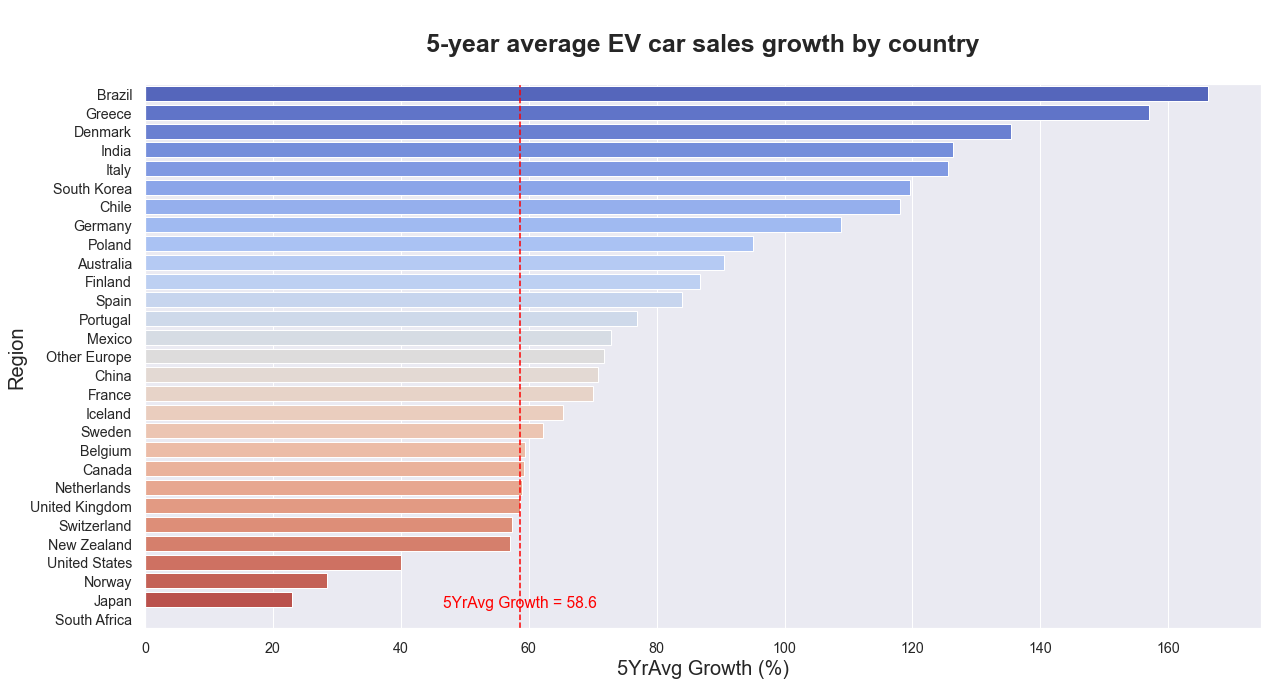

In [20]:
df_growth_evsales = df_hist_EVCarSales.groupby('region').sum().reset_index().set_index('region').pct_change(axis = 1).round(2)*100
df_avgG_evsales = pd.DataFrame()
df_avgG_evsales['5YrAvg'] = df_growth_evsales.iloc[:, -5:].mean(axis=1).round(2)
df_avgG_evsales['10YrAvg'] = df_growth_evsales.iloc[:, -10:].mean(axis=1).round(2)
df_avgG_evsales['2010-2021Avg'] = df_growth_evsales.mean(axis=1).round(2)

df_growth_evsales_exworld = df_sum_evsales_exworld.set_index('region').pct_change(axis = 1).round(2)*100
df_avgG_evsales_exworld = pd.DataFrame()
df_avgG_evsales_exworld['5YrAvg'] = df_growth_evsales_exworld.iloc[:, -5:].mean(axis=1).round(2)
df_avgG_evsales_exworld['10YrAvg'] = df_growth_evsales_exworld.iloc[:, -10:].mean(axis=1).round(2)
df_avgG_evsales_exworld['2010-2021Avg'] = df_growth_evsales_exworld.mean(axis=1).round(2)

# plot
fig, ax = plt.subplots(figsize=(20, 10))
plott = sns.barplot(x=df_avgG_evsales_exworld['5YrAvg'], 
y=df_avgG_evsales_exworld.index, 
order=df_avgG_evsales_exworld.sort_values(by='5YrAvg', ascending=False).index,
palette= 'coolwarm')

# add overall title
plott.axes.set_title('\n5-year average EV car sales growth by country', fontsize=25, fontweight='bold', y=1.05)
plott.set_ylabel('Region', fontsize=20)
plott.set_xlabel('5YrAvg Growth (%)', fontsize=20)
sns.set(font_scale = 1.3)

val = df_avgG_evsales[df_avgG_evsales.index == 'World']['5YrAvg'].values[0]
plott.axvline(val, color='red', linestyle='--')
plott.text(val,.06, f'5YrAvg Growth = {val}',
 color='red', transform=plott.get_xaxis_transform(), ha='center', va='top')

* 5Y AVG Sale Growth vs. 5Y AVG Sale

Text(0.5, 1.04, '(Size by 5-year average EV car sales)')

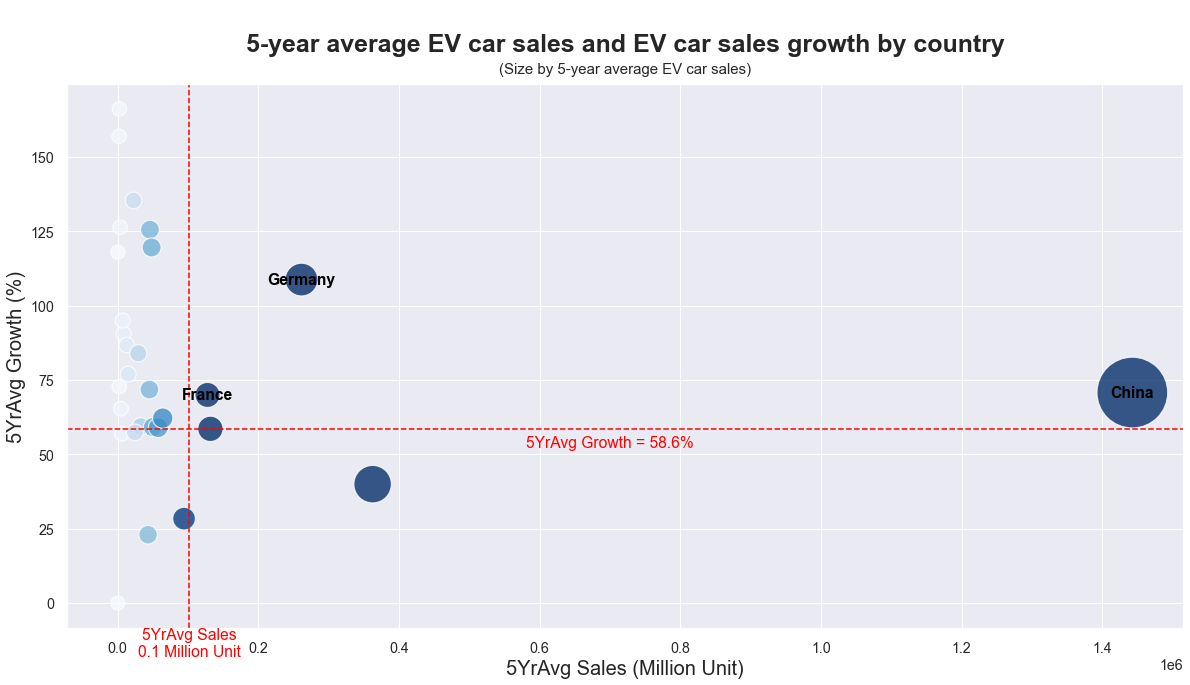

In [21]:
df_avg_SalesNGrowth = df_avg_evsales_exworld.merge(df_avgG_evsales_exworld.reset_index(inplace=False), on='region', how='left', suffixes=('_Sales', '_Growth'))

# plot
fig, ax = plt.subplots(figsize=(20, 10))

plott = sns.scatterplot(data=df_avg_SalesNGrowth, x= '5YrAvg_Sales', y='5YrAvg_Growth',
hue='5YrAvg_Sales',size='5YrAvg_Sales', sizes=(200, 5000),
legend='brief', alpha=0.8, hue_norm=(0,100000), palette='Blues')

plott.axes.set_title('\n5-year average EV car sales and EV car sales growth by country', fontsize=25, fontweight='bold', y=1.05)
plott.set_ylabel('5YrAvg Growth (%)', fontsize=20)
plott.set_xlabel('5YrAvg Sales (Million Unit)', fontsize=20)
sns.set(font_scale = 1.3)
plott.get_legend().remove()

val = df_avg_evsales_exworld['5YrAvg'].mean().astype(int)
plott.axvline(val, color='red', linestyle='--')
plt.annotate(f'5YrAvg Sales\n{(val/1000000).round(2)} Million Unit', xy=(val, -8), color='red', ha='center', va='top')

val2 = df_avgG_evsales[df_avgG_evsales.index == 'World']['5YrAvg'].values[0]
plott.axhline(val2, color='red', linestyle='--')
plt.annotate(f'5YrAvg Growth = {val2}%', xy=(700000, val2-2), ha='center', va='top', color='red')

for row in range(0,df_avg_SalesNGrowth.shape[0]):
    if (df_avg_SalesNGrowth['5YrAvg_Sales'][row] > val) & (df_avg_SalesNGrowth['5YrAvg_Growth'][row] > val2):
        plott.text(df_avg_SalesNGrowth['5YrAvg_Sales'][row], df_avg_SalesNGrowth['5YrAvg_Growth'][row], 
        df_avg_SalesNGrowth['region'][row], ha='center', va = 'center',
        size='medium', color='black', weight='semibold')

# set sub title
plott.text(0.5, 1.04, '(Size by 5-year average EV car sales)',
transform=plott.transAxes, fontsize=15, fontweight='light', ha='center', va='top')  

จะเห็นได้ว่าเมื่อนำค่าเฉลี่ยย้อนหลัง 5 ปีของยอดขายรถ EV มาเปรียบเทียบคู่กับค่าเฉลี่ยย้อนหลัง 5 ปีการเติบโตของยอดขาย จะพบว่า
* มีเพียง 3 ประเทศเท่านั้นที่มีมีค่าดังกล่าวสูงกว่าค่าเฉลี่ยของประเทศอื่นๆ
* และสิ่งที่น่าแปลกใจคือ ประเทศสหรัฐอเมริกา ซึ่งถือเป็นประเทศยักษ์ใหญ่และมีบริษัทที่ทำเกี่ยวกับ EV Car อยู่เป็นจำนวนมากกลับมียอดขายและการเติบโตที่ต่ำกว่าค่าเฉลี่ย

## EV Car Share & EV Car Share Growth : Breakdown รายประเทศ

และหากพิจารณาสัดส่วนยอดขายรถ EV เมื่อเทียบกับรถยนต์ประเภทอื่นๆ ในปี 2021 นั้นจะพบว่า
* กลุ่มประเทศในทวีปยุโรป โดยเฉพาะแถบสแกนดิเนเวียนั้น นิยมที่จะซื้อรถ EV เป็นอย่างมาก โดยเฉพาะนอร์เวย์ที่มีสัดส่วนการซื้อรถ EV ถุง 86.17% เมื่อเทียบกับยอดซื้อรถทั้งหมด
* ในส่วนของประเทศจีนเ ถึงแม้จะมียอดซื้อรถยนต์ EV มากที่สุดในโลก แต่หากพิจารณาตามสัดส่วนการซื้อรถ EV เทียบกับรถยนต์ประเภทอื่นๆ นั้น พบว่ามีสัดส่วนเพียง 16% เท่านั้น
* ขณะที่ประเทศสหรัฐอเมริกากลับมีสัดส่วนการซื้อรถ EV เพียงแค่ 4.56% ซึ่งต่ำกว่าค่าเฉลี่ย


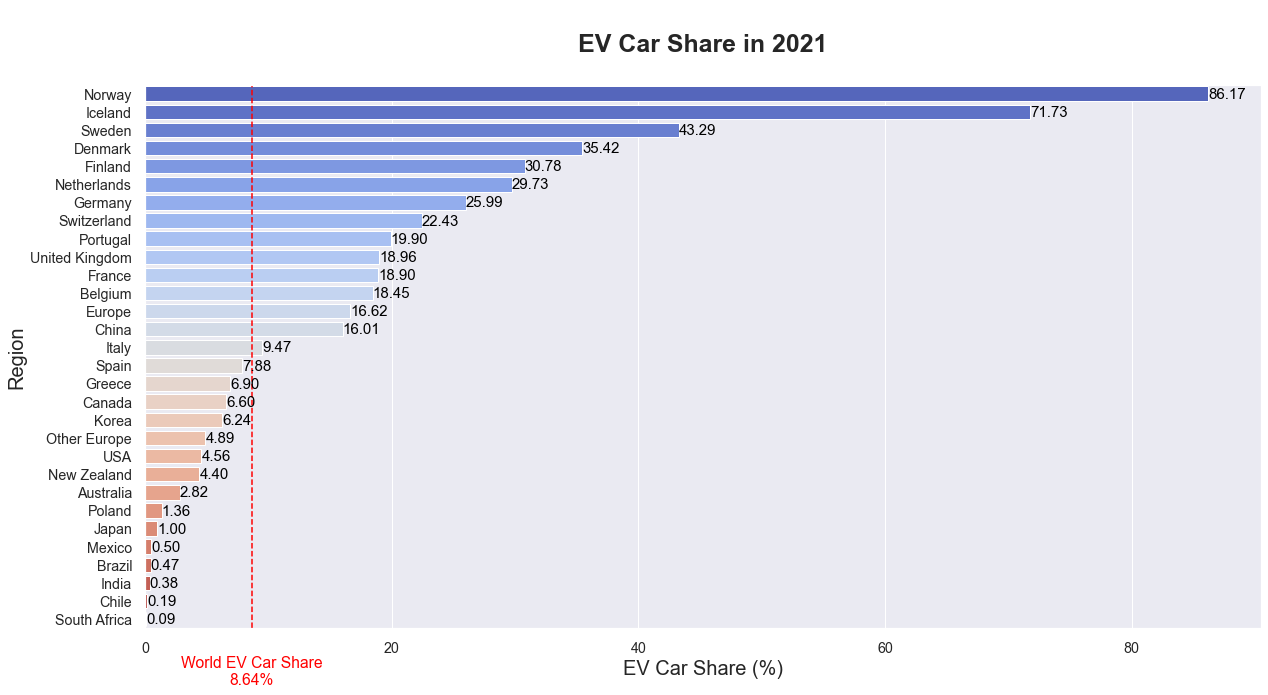

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.barplot(x=df_hist_EVCarShare[df_hist_EVCarShare.region != 'World'][2021],
y=df_hist_EVCarShare[df_hist_EVCarShare.region != 'World']['region'],
order=df_hist_EVCarShare[df_hist_EVCarShare.region != 'World'].sort_values(by=2021, ascending=False)['region'],
palette='coolwarm')

ax.axes.set_title('\nEV Car Share in 2021', fontsize=25, fontweight='bold', y=1.05)

ax.set_ylabel('Region', fontsize=20)
ax.set_xlabel('EV Car Share (%)', fontsize=20)

sns.set(font_scale = 1.3)

val = df_hist_EVCarShare[df_hist_EVCarShare.region == 'World'][2021].values[0]
ax.axvline(val, color='red', linestyle='--')
ax.text(val,-.05, f'World EV Car Share\n{val}%', color='red', transform=ax.get_xaxis_transform(), ha='center', va='top')

# show bar values if value > 1
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y()+0.55*p.get_height()),
        ha='left', va='center', color='black', size=15, fontweight='light')

# คาดการณ์ยอดขายรถ EV ในอนาคต

1. STEP TABLE -> Check + clean ข้อมูล STEPS
* 1.1 ข้อมูล 2020 2021 ซึ่งเป็น Historical data ตรงกับข้อมูลในตารางเดิมที่ทำไหม?
* 1.2 ข้อมูล 2025 2030 ทุกประเทศรวมกับ = world?

* 1.1 ข้อมูล 2020 2021 ซึ่งเป็น Historical data ตรงกับข้อมูลในตารางเดิมที่ทำไหม?


In [23]:
df_proj_steps_EVCarSales = df_proj_steps[(df_proj_steps.parameter == 'EV sales') & (df_proj_steps['mode'] == 'Cars')]

df_proj_steps_EVCarSales.replace('USA', 'United States', inplace=True)
# Add continent column
df_proj_steps_EVCarSales['continent'] = df_proj_steps_EVCarSales[(df_proj_steps_EVCarSales.region != 'Europe') & (df_proj_steps_EVCarSales.region != 'Rest of the world') & (df_proj_steps_EVCarSales.region != 'World')]['region'].apply(lambda x: my_world.get_country_continent_name(x))
df_proj_steps_EVCarSales.loc[df_proj_steps_EVCarSales.region == 'Europe', 'continent'] = 'Europe'
df_proj_steps_EVCarSales.loc[df_proj_steps_EVCarSales.region == 'Rest of the world', 'continent'] = 'Rest of the world'
df_proj_steps_EVCarSales.loc[df_proj_steps_EVCarSales.region == 'World', 'continent'] = 'World'


# filter df_proj_steps_EVCarSales  year = 2020 or 2021
df_proj_steps_EVCarSales_20_21 = df_proj_steps_EVCarSales[(df_proj_steps_EVCarSales.year == 2020) | (df_proj_steps_EVCarSales.year == 2021)].groupby(['region', 'year', 'continent']).sum().reset_index()
df_proj_steps_EVCarSales_20_21 = df_proj_steps_EVCarSales_20_21[['region', 'continent','year', 'value']]

long_total_evsales = pd.melt(total_evsales, id_vars=['region'],var_name='year', value_name='EV Car Sales')

long_total_evsales_20_21 = long_total_evsales[(long_total_evsales.year == 2020) | (long_total_evsales.year == 2021)].groupby(['region', 'year']).sum().reset_index()

# Add continent column
long_total_evsales_20_21['continent'] = long_total_evsales_20_21[(long_total_evsales_20_21.region != 'Europe') & (long_total_evsales_20_21.region != 'Other Europe') & (long_total_evsales_20_21.region != 'World')]['region'].apply(lambda x: my_world.get_country_continent_name(x))
long_total_evsales_20_21.loc[long_total_evsales_20_21.region == 'Other Europe', 'continent'] = 'Europe'

China = long_total_evsales_20_21[long_total_evsales_20_21.region == 'China'][['region', 'continent','year', 'EV Car Sales']]
India = long_total_evsales_20_21[long_total_evsales_20_21.region == 'India']
Usa = long_total_evsales_20_21[long_total_evsales_20_21.region == 'United States']
World = long_total_evsales_20_21[long_total_evsales_20_21.region == 'World']

Europe = long_total_evsales_20_21[long_total_evsales_20_21.continent == 'Europe'].groupby(['year', 'continent']).sum().reset_index()
Rest = long_total_evsales_20_21[(long_total_evsales_20_21.region != 'China') &\
                         (long_total_evsales_20_21.region != 'India') &\
                         (long_total_evsales_20_21.region != 'United States') &\
                         (long_total_evsales_20_21.region != 'World') &\
                         (long_total_evsales_20_21.continent != 'Europe')].groupby(['year']).sum().reset_index()

df_hist_evsales_20_21 = pd.DataFrame()

data = [China, Europe, India, Rest, Usa, World]

df_hist_evsales_20_21 = df_hist_evsales_20_21.append(data)

# Edit Some Rows like DF df_proj_steps_EVCarSales_20_21
df_hist_evsales_20_21.loc[df_hist_evsales_20_21.continent == 'Europe', 'region'] = 'Europe'
df_hist_evsales_20_21.loc[df_hist_evsales_20_21.region == 'World', 'continent'] = 'World'
df_hist_evsales_20_21.fillna('Rest of the world', inplace=True)
df_hist_evsales_20_21.rename(columns={'EV Car Sales': 'value'}, inplace=True)

df_hist_evsales_20_21

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/352857683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proj_steps_EVCarSales.replace('USA', 'United States', inplace=True)
C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/352857683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proj_steps_EVCarSales['continent'] = df_proj_steps_EVCarSales[(df_proj_steps_EVCarSales.region != 'Europe') & (df_proj_steps_EVCarSales.region != 'Rest of the world') & (df_proj_steps_EVCarSales.region != 'World')]['region'].apply(lambda x: my_world.get_country_con

,region,continent,year,value
10,China,Asia,2020,1159582.0
11,China,Asia,2021,3334161.0
0,Europe,Europe,2020,1370944.0
1,Europe,Europe,2021,2283022.0
24,India,Asia,2020,3165.0
25,India,Asia,2021,11739.0
0,Rest of the world,Rest of the world,2020,138452.0
1,Rest of the world,Rest of the world,2021,265921.0
56,United States,North America,2020,295399.0
57,United States,North America,2021,631152.0


In [24]:
long_total_evsales = pd.melt(total_evsales, id_vars=['region'],var_name='year', value_name='EV Car Sales')

long_total_evsales_20_21 = long_total_evsales[(long_total_evsales.year == 2020) | (long_total_evsales.year == 2021)].groupby(['region', 'year']).sum().reset_index()

# Add continent column
long_total_evsales_20_21['continent'] = long_total_evsales_20_21[(long_total_evsales_20_21.region != 'Europe') & (long_total_evsales_20_21.region != 'Other Europe') & (long_total_evsales_20_21.region != 'World')]['region'].apply(lambda x: my_world.get_country_continent_name(x))
long_total_evsales_20_21.loc[long_total_evsales_20_21.region == 'Other Europe', 'continent'] = 'Europe'

long_total_evsales_20_21.head()

,region,year,EV Car Sales,continent
0,Australia,2020,6938.0,Oceania
1,Australia,2021,20700.0,Oceania
2,Belgium,2020,48076.0,Europe
3,Belgium,2021,70680.0,Europe
4,Brazil,2020,2452.0,South America


In [25]:
China = long_total_evsales_20_21[long_total_evsales_20_21.region == 'China'][['region', 'continent','year', 'EV Car Sales']]
India = long_total_evsales_20_21[long_total_evsales_20_21.region == 'India']
Usa = long_total_evsales_20_21[long_total_evsales_20_21.region == 'United States']
World = long_total_evsales_20_21[long_total_evsales_20_21.region == 'World']

Europe = long_total_evsales_20_21[long_total_evsales_20_21.continent == 'Europe'].groupby(['year', 'continent']).sum().reset_index()

Rest = long_total_evsales_20_21[(long_total_evsales_20_21.region != 'China') &\
                         (long_total_evsales_20_21.region != 'India') &\
                         (long_total_evsales_20_21.region != 'United States') &\
                         (long_total_evsales_20_21.region != 'World') &\
                         (long_total_evsales_20_21.continent != 'Europe')].groupby(['year']).sum().reset_index()

In [26]:
df_hist_evsales_20_21 = pd.DataFrame()

data = [China, Europe, India, Rest, Usa, World]

df_hist_evsales_20_21 = df_hist_evsales_20_21.append(data)

# Edit Some Rows like DF df_proj_steps_EVCarSales_20_21
df_hist_evsales_20_21.loc[df_hist_evsales_20_21.continent == 'Europe', 'region'] = 'Europe'
df_hist_evsales_20_21.loc[df_hist_evsales_20_21.region == 'World', 'continent'] = 'World'
df_hist_evsales_20_21.fillna('Rest of the world', inplace=True)

df_hist_evsales_20_21.rename(columns={'EV Car Sales': 'value'}, inplace=True)

df_hist_evsales_20_21


C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/820205287.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hist_evsales_20_21 = df_hist_evsales_20_21.append(data)


,region,continent,year,value
10,China,Asia,2020,1159582.0
11,China,Asia,2021,3334161.0
0,Europe,Europe,2020,1370944.0
1,Europe,Europe,2021,2283022.0
24,India,Asia,2020,3165.0
25,India,Asia,2021,11739.0
0,Rest of the world,Rest of the world,2020,138452.0
1,Rest of the world,Rest of the world,2021,265921.0
56,United States,North America,2020,295399.0
57,United States,North America,2021,631152.0


In [27]:
compare_data = df_proj_steps_EVCarSales_20_21.join(df_hist_evsales_20_21.set_index(['region', 'year', 'continent']), on=['region', 'year', 'continent'], how='left', lsuffix='_proj', rsuffix='_hist(after clean)')
compare_data['Difference'] = compare_data['value_hist(after clean)'] - compare_data['value_proj']
compare_data['%Difference'] = ((compare_data['value_hist(after clean)'] - compare_data['value_proj']) / compare_data['value_proj'] * 100).round(2)
compare_data

,region,continent,year,value_proj,value_hist(after clean),Difference,%Difference
0,China,Asia,2020,1159582.0,1159582.0,0.0,0.00
1,China,Asia,2021,3334161.0,3334161.0,0.0,0.00
2,Europe,Europe,2020,1372245.0,1370944.0,-1301.0,-0.09
3,Europe,Europe,2021,2284938.0,2283022.0,-1916.0,-0.08
4,India,Asia,2020,3165.0,3165.0,0.0,0.00
5,India,Asia,2021,11739.0,11739.0,0.0,0.00
6,Rest of the world,Rest of the world,2020,162896.0,138452.0,-24444.0,-15.01
7,Rest of the world,Rest of the world,2021,309659.0,265921.0,-43738.0,-14.12
8,United States,North America,2020,295399.0,295399.0,0.0,0.00
9,United States,North America,2021,631152.0,631152.0,0.0,0.00


--> ข้อมูลไม่ตรงกัน!!

In [28]:
# แก้ df_proj_steps_EVCarSales ปี 2020 2021 ให้ตรงกับ Data ที่เคย Clean ไว้

# เปลี่ยน Data ปี 2020 และ 2021 ใหม่ + concat กับข้อมูล ปี 2025, 2030
df_sum_proj_step = df_proj_steps_EVCarSales.groupby(['region', 'year', 'continent']).sum().reset_index()
df_sum_proj_step = pd.concat([df_hist_evsales_20_21, df_sum_proj_step[(df_sum_proj_step.year != 2020) & (df_sum_proj_step.year != 2021)]])
df_sum_proj_step.head()

,region,continent,year,value
10,China,Asia,2020,1159582.0
11,China,Asia,2021,3334161.0
0,Europe,Europe,2020,1370944.0
1,Europe,Europe,2021,2283022.0
24,India,Asia,2020,3165.0


1.2 ข้อมูล 2025 2030 ทุกประเทศรวมกับ = world?

In [29]:
df_sum_proj_step['value'] = df_sum_proj_step['value'].astype(int)

# 2025
all_region_2025 = df_sum_proj_step[(df_sum_proj_step.year == 2025) & (df_sum_proj_step.region != 'World')]['value'].sum()
world_2025 = df_sum_proj_step[(df_sum_proj_step.year == 2025) & (df_sum_proj_step.region == 'World')]['value'].values[0]

print('Sum All Region Except World 2025 = ', all_region_2025)
print('World 2025 = ', world_2025)
print('Difference 2025 = ', all_region_2025 - world_2025)

# 2030
all_region_2030 = df_sum_proj_step[(df_sum_proj_step.year == 2030) & (df_sum_proj_step.region != 'World')]['value'].sum()
world_2030 = df_sum_proj_step[(df_sum_proj_step.year == 2030) & (df_sum_proj_step.region == 'World')]['value'].values[0]

print('\nSum All Region Except World 2030 = ', all_region_2030)
print('World 2030  = ', world_2030)
print('Difference 2030 = ', all_region_2030 - world_2030)

Sum All Region Except World 2025 =  15715021
World 2025 =  15715021
Difference 2025 =  0

Sum All Region Except World 2030 =  27696624
World 2030  =  27696626
Difference 2030 =  -2


--> ข้อมูลไม่ตรงกัน!!

In [30]:
# แก้ไข Row World ใหม่ = sum all region except world
df_sum_proj_step.loc[(df_sum_proj_step.year == 2025) & (df_sum_proj_step.region == 'World'), 'value'] = all_region_2025
df_sum_proj_step.loc[(df_sum_proj_step.year == 2030) & (df_sum_proj_step.region == 'World'), 'value'] = all_region_2030

2. APS Table --> Check + clean ข้อมูล STEPS
* 2.1 ข้อมูล 2020 2021 ซึ่งเป็น Historical data ตรงกับข้อมูลในตารางเดิมที่ทำไหม?
* 2.2 ข้อมูล 2025 2030 ทุกประเทศรวมกับ = world?

In [31]:
df_proj_aps_EVCarSales = df_proj_aps[(df_proj_aps.parameter == 'EV sales') & (df_proj_aps['mode'] == 'Cars')]

df_proj_aps_EVCarSales.replace('USA', 'United States', inplace=True)

# Add continent column
df_proj_aps_EVCarSales['continent'] = df_proj_aps_EVCarSales[(df_proj_aps_EVCarSales.region != 'Europe') & (df_proj_aps_EVCarSales.region != 'Rest of the world') & (df_proj_aps_EVCarSales.region != 'World')]['region'].apply(lambda x: my_world.get_country_continent_name(x))
df_proj_aps_EVCarSales.loc[df_proj_aps_EVCarSales.region == 'Europe', 'continent'] = 'Europe'
df_proj_aps_EVCarSales.loc[df_proj_aps_EVCarSales.region == 'Rest of the world', 'continent'] = 'Rest of the world'
df_proj_aps_EVCarSales.loc[df_proj_aps_EVCarSales.region == 'World', 'continent'] = 'World'

df_proj_aps_EVCarSales.head()

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/2183010626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proj_aps_EVCarSales.replace('USA', 'United States', inplace=True)
C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/2183010626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proj_aps_EVCarSales['continent'] = df_proj_aps_EVCarSales[(df_proj_aps_EVCarSales.region != 'Europe') & (df_proj_aps_EVCarSales.region != 'Rest of the world') & (df_proj_aps_EVCarSales.region != 'World')]['region'].apply(lambda x: my_world.get_country_continent_nam

,region,category,parameter,mode,powertrain,year,unit,value,continent
925,China,Projection-APS,EV sales,Cars,BEV,2020,sales,931291.0,Asia
926,China,Projection-APS,EV sales,Cars,PHEV,2020,sales,228291.0,Asia
1052,China,Projection-APS,EV sales,Cars,BEV,2021,sales,2734013.0,Asia
1053,China,Projection-APS,EV sales,Cars,PHEV,2021,sales,600148.0,Asia
1231,China,Projection-APS,EV sales,Cars,BEV,2025,sales,7060630.0,Asia


* 2.1 ข้อมูล 2020 2021 ตรงไหม (APS Table)

In [32]:
# filter df_proj_aps_EVCarSales  year = 2020 or 2021
df_proj_aps_EVCarSales_20_21 = df_proj_aps_EVCarSales[(df_proj_aps_EVCarSales.year == 2020) | (df_proj_aps_EVCarSales.year == 2021)].groupby(['region', 'year', 'continent']).sum().reset_index()
df_proj_aps_EVCarSales_20_21 = df_proj_aps_EVCarSales_20_21[['region', 'continent','year', 'value']]

compare_data_aps = df_proj_aps_EVCarSales_20_21.join(df_hist_evsales_20_21.set_index(['region', 'year', 'continent']), on=['region', 'year', 'continent'], how='left', lsuffix='_proj', rsuffix='_hist(after clean)')

compare_data_aps['Difference'] = compare_data_aps['value_hist(after clean)'] - compare_data_aps['value_proj']
compare_data_aps['%Difference'] = ((compare_data_aps['value_hist(after clean)'] - compare_data_aps['value_proj']) / compare_data_aps['value_proj'] * 100).round(2)
compare_data_aps

,region,continent,year,value_proj,value_hist(after clean),Difference,%Difference
0,China,Asia,2020,1159582.0,1159582.0,0.0,0.00
1,China,Asia,2021,3334161.0,3334161.0,0.0,0.00
2,Europe,Europe,2020,1372245.0,1370944.0,-1301.0,-0.09
3,Europe,Europe,2021,2284938.0,2283022.0,-1916.0,-0.08
4,India,Asia,2020,3165.0,3165.0,0.0,0.00
5,India,Asia,2021,11739.0,11739.0,0.0,0.00
6,Rest of the world,Rest of the world,2020,162896.0,138452.0,-24444.0,-15.01
7,Rest of the world,Rest of the world,2021,309659.0,265921.0,-43738.0,-14.12
8,United States,North America,2020,295399.0,295399.0,0.0,0.00
9,United States,North America,2021,631152.0,631152.0,0.0,0.00


In [33]:
# เปลี่ยน Data ปี 2020 และ 2021 ใหม่ + concat กับข้อมูล ปี 2025, 2030
df_sum_proj_aps = df_proj_aps_EVCarSales.groupby(['region', 'year', 'continent']).sum().reset_index()

df_sum_proj_aps = pd.concat([df_hist_evsales_20_21, df_sum_proj_aps[(df_sum_proj_aps.year != 2020) & (df_sum_proj_aps.year != 2021)]])
df_sum_proj_aps.head()

,region,continent,year,value
10,China,Asia,2020,1159582.0
11,China,Asia,2021,3334161.0
0,Europe,Europe,2020,1370944.0
1,Europe,Europe,2021,2283022.0
24,India,Asia,2020,3165.0


2.2 ข้อมูล 2025 2030 ทุกประเทศรวมกับ = world?

In [34]:
df_sum_proj_aps['value'] = df_sum_proj_aps['value'].astype(int)

# 2025
all_region_2025aps = df_sum_proj_aps[(df_sum_proj_aps.year == 2025) & (df_sum_proj_aps.region != 'World')]['value'].sum()
world_2025aps = df_sum_proj_aps[(df_sum_proj_aps.year == 2025) & (df_sum_proj_aps.region == 'World')]['value'].values[0]
print('Sum All Region Except World 2025 = ', all_region_2025aps)
print('World 2025 = ', world_2025aps)
print('Difference 2025 = ', all_region_2025aps - world_2025aps)

# 2030
all_region_2030aps = df_sum_proj_aps[(df_sum_proj_aps.year == 2030) & (df_sum_proj_aps.region != 'World')]['value'].sum()
world_2030aps = df_sum_proj_aps[(df_sum_proj_aps.year == 2030) & (df_sum_proj_aps.region == 'World')]['value'].values[0]
print('\nSum All Region Except World 2030 = ', all_region_2030aps)
print('World 2030 = ', world_2030aps)
print('Difference 2030 = ', all_region_2030aps - world_2030aps)

Sum All Region Except World 2025 =  19689362
World 2025 =  19689362
Difference 2025 =  0

Sum All Region Except World 2030 =  43172429
World 2030 =  43172428
Difference 2030 =  1


In [35]:
# แก้ไข Row World ใหม่ = sum all region except world
df_sum_proj_aps.loc[(df_sum_proj_aps.year == 2025) & (df_sum_proj_aps.region == 'World'), 'value'] = all_region_2025aps
df_sum_proj_aps.loc[(df_sum_proj_aps.year == 2030) & (df_sum_proj_aps.region == 'World'), 'value'] = all_region_2030aps

3. Concat STEP & APS

In [36]:
# concat df_proj_steps_EVCarSales & df_proj_aps_EVCarSales
df_proj_EVCarSales = pd.concat([df_proj_steps_EVCarSales, df_proj_aps_EVCarSales], axis=0)

df_proj_sum_sales1 = df_proj_EVCarSales.groupby(['region', 'category', 'year'])['value'].sum().reset_index()
df_proj_sum_sales2 = df_proj_EVCarSales.groupby(['region', 'category', 'year'])['value'].sum().unstack().reset_index()


4. Plot Forcasting Data

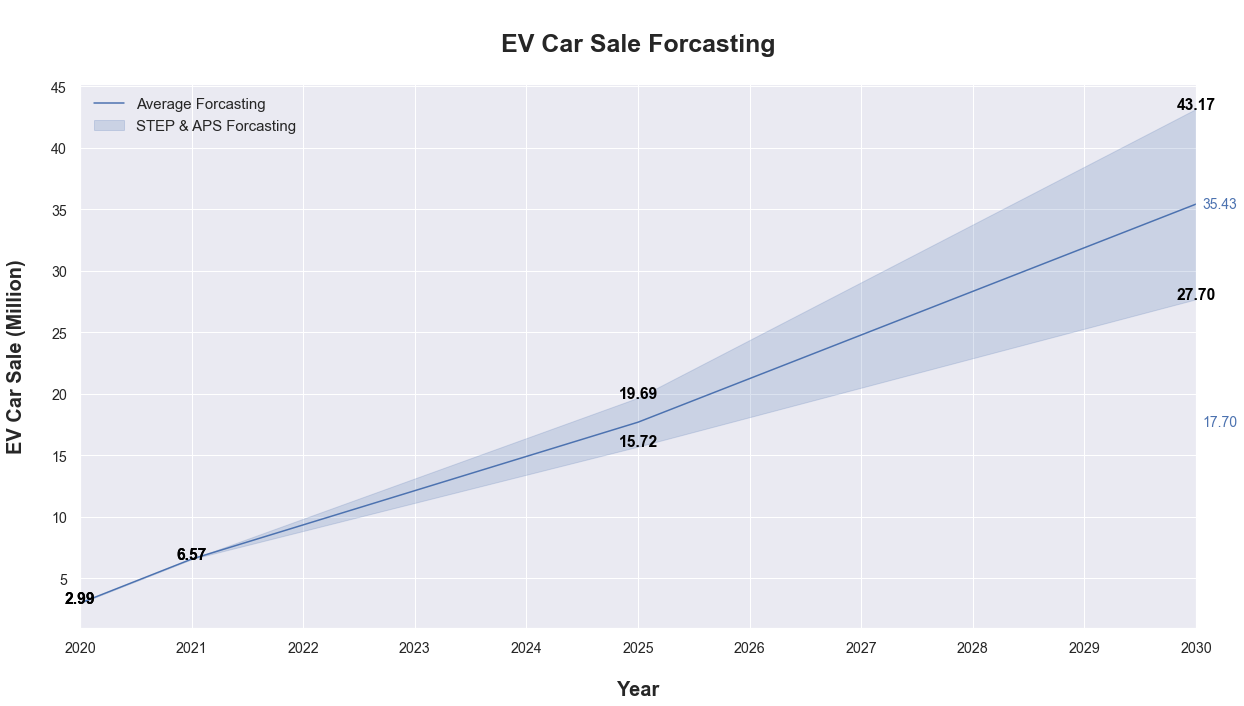

In [37]:
from matplotlib.pyplot import errorbar


dataa = df_proj_sum_sales1[df_proj_sum_sales1.region == 'World']

fig, ax = plt.subplots(figsize=(20, 10))

ax = sns.lineplot(x='year', y='value', data=dataa, err_style='band', ci=95, markers=True, dashes=False)
ax.axes.set_title('\nEV Car Sale Forcasting', fontsize=25, fontweight='bold', y=1.05)

ax.set_xlabel('\nYear', fontsize=20, fontweight='bold', labelpad=3)
ax.set_ylabel('EV Car Sale (Million)\n', fontsize=20, fontweight='bold', labelpad=3)
sns.set(font_scale = 1.3)

# Change the tick label size
scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

ax.set_xticks(2020 + np.arange(0, 11, 1))
ax.set_xlim(2020, 2030)
ax.legend(labels=['Average Forcasting','STEP & APS Forcasting'], loc='upper left', fontsize=15)

# show database on line
for line in ax.lines:
    y25 = line.get_ydata()[-2]
    y30 = line.get_ydata()[-1]
    ax.annotate('{:.2f}'.format(y30/1000000), xy=(1, y30), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), textcoords="offset points", size=14, va='center')
    ax.annotate('{:.2f}'.format(y25/1000000), xy=(1, y25), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), textcoords="offset points", size=14, va='center')

for lin in range(0, dataa.shape[0]):
    ax.text(dataa.iloc[lin]['year'], dataa.iloc[lin]['value'], '{:.2f}'.format(dataa.iloc[lin]['value']/1000000), ha='center', va = 'baseline', size='medium', color='black', weight='semibold')

In [38]:
dataa = df_proj_sum_sales1[df_proj_sum_sales1.region != 'World']

fig = px.bar(dataa, x="category", y="value", facet_col="year", color="region",
title="EV Car Sales Forcasting", color_discrete_sequence=px.colors.sequential.Agsunset)
# text=['{:.2}'.format(x / 1000000) for x in dataa['value']])
# text_auto= 'True'



# fig.update_xaxes(visible=False)

for i in range(1, 5):
    fig.update_xaxes(title_text="", row=1, col=i)

for i in range(1,3):
    fig.update_xaxes(ticktext=['', ''], tickvals=[0, 1], row=1, col=i)

for i in range(3,5):
    fig.update_xaxes(ticktext=['APS', 'STEPS'], tickvals=[0, 1], row=1, col=i)



fig.show()

ข้อมูล Forecasting
* ยอดขายรถ EV ทั่วโลกคาดเพิ่มขึ้นก้าวกระโดดในปี 2030
* อ้างอิง Global Electric Vehicle Outlook 2022 โดย IEA มีการคาดการณ์ว่า จำนวนยอดขายรถ EV ทั่วโลกจะยังคงมีการเพิ่มขึ้นอย่างต่อเนื่องไปในระยะยาว จากนโยบายที่ชัดเจนของประเทศต่างๆ ทั่วโลกเกี่ยวกับรถ EV และสิ่งแวดล้อม รวมถึงแผนของค่ายรถยนต์ต่างๆ ทั่วโลกในการพัฒนารถ EV
* IEA มีการคาดการณ์ว่ายอดขายรถ EV จะเพิ่มขึ้นจากจำนวนราว 6.57 ล้านคันในปี 2021 มาอยู่ที่ 15.72-19.69 ล้านคันในปี 2025 และ 27.7-43.17 ล้านคันในปี 2030 (ค่าเฉลี่ย:17.7 ล้านคันในปี 2025 และ 35.43 ล้านคันในปี 2030)
* โดยประเทศจีนจะยังคงครองส่วนแบ่งตลาดมากที่สุด ในขณะที่ประเทศอินเดียมี แนวโน้มเติบโตมากในอนาคต จากการนโยบายสนับสนุนรถ EV และตลาดที่ใหญ่ของประเทศอินเดีย โดยยอดขายยานยนต์ (รวมรถ ICE) ในประเทศอินเดียอยู่ในอันดับ 3ของโลกในปี 2021

หมายเหตุ:
* Announced Pledges Scenario (APS): คาดการณ์โดยอิงกับนโยบายหรือมาตรการของประเทศต่างๆ ที่เกี่ยวข้องกับรถ EV และเป้าหมายด้านสิ่งแวดล้อม
* Stated Policies Scenario (STEPS): คาดการณ์โดยอิงกับนโยบายหรือมาตรการของประเทศต่างๆ ที่เกี่ยวข้องกับรถ EV



# เปรียบเทียบผู้นำด้าน EV Car "Tesla & BYD" 

In [39]:
# Create table tesla
statment_tesla = pd.read_excel('Statement_tesla.xlsx')
statment_tesla.drop(columns=['Unnamed: 6'], inplace=True)

# Rename columns
year = 2016
for col in statment_tesla.columns[1:]:
    year = year + 1
    statment_tesla.rename(columns={col:year}, inplace=True)

statment_tesla.head()


,statement,2017,2018,2019,2020,2021,2022,2023,2024
0,REVENUE,11758.751,21461.268,24578,31536,53823,84937.5,121561,149066.745
1,YoY Growth %,0.67979,0.825132,0.145226,0.283099,0.706716,0.578089,0.431182,0.226271
2,AUTOMOTIVE,9641.29981,18514.983,20821,27236,47232,75663.3,109503.15,126703
3,YoY Growth %,0.518132,0.920382,0.124549,0.308102,0.734175,0.60195,0.447243,0.157072
4,AUTMOTIVE LEASING,1106.54797,883.461,869,1052,1642,2630.455,3761.3545,5740.0675


In [40]:
# Create talbe byd
statement_byd = pd.read_excel('Statement_BYD.xlsx')
statement_byd.drop(columns=['Unnamed: 6'], inplace=True)

# Rename columns
year = 2016
for col in statement_byd.columns[1:]:
    year = year + 1
    statement_byd.rename(columns={col:year}, inplace=True)

statement_byd.head()


,statement,2017,2018,2019,2020,2021,2022,2023,2024
0,REVENUE,14767.805633,18133.673592,17810.72546,21834.591606,30136.976436,52748.679448,71876.210959,89542.805354
1,YoY Growth %,0.023627,0.227919,-0.017809,0.225924,0.38024,0.750298,0.362616,0.245792
2,COST OF GOODS SOLD,11959.771612,15159.696458,14908.573341,17672.97797,26212.728528,45767.847183,63586.586726,77352.621305
3,YoY Growth %,0.056486,0.267557,-0.016565,0.185424,0.483209,0.746016,0.389329,0.216493
4,GROSS INCOME,2622.678427,2973.977133,2902.152119,4034.952593,3924.247909,8143.892917,12490.658115,16212.911322


## 1. Revenue

In [41]:
tc = 'mediumslateblue'
bc = 'rgb(214, 39, 40)'

In [42]:
# Create Revenue table
rev_tesla = statment_tesla.iloc[:2,:]

rev_tesla.statement.unique() # เจอชื่อแปลกๆ ตอนแรกไม่รู้เลยพล็อตกราฟไม่ได้ '\xa0\xa0\xa0\xa0YoY Growth %' ต้องแก้ไข้
rev_tesla.head()

# Edit Row Values in row 1 and 2
rev_tesla.iloc[0,0] = 'Revenue'
rev_tesla.iloc[1,0] = 'Revenue Growth (%Change YoY)'

# Convert YoY Growth to percentage
rev_tesla.iloc[1,1:] = rev_tesla.iloc[1,1:]*100

# melt the data
rev_tesla = pd.melt(rev_tesla, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
rev_tesla['values'] = pd.to_numeric(rev_tesla['values'], errors='coerce')

# column values to float 2 decimal
rev_tesla['values'] = rev_tesla['values'].apply(lambda x: round(x,2))

# Plot Revenue
fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Scatter(
    x=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['years'],
    y=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['values'],
    name='Revenue Growth (%Change YoY)',
    mode='lines+markers',
    marker_line_width=2, marker_size=10
), row=1, col=1)

fig.append_trace(go.Bar(
    x=rev_tesla[rev_tesla.statement == 'Revenue']['years'],
    y=rev_tesla[rev_tesla.statement == 'Revenue']['values'],
    name='Revenue',
    marker_color='MediumPurple',
), row=2, col=1)

fig.update_layout(height=800, width=1000,
title_text="Revenue and Revenue Growth (%Change YoY) of Tesla",
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
fig.update_xaxes(title_text="Years", row=1, col=1)
fig.update_xaxes(title_text="Years", row=2, col=1)
fig.update_yaxes(title_text="Revenue Growth (%Change YoY)", row=1, col=1)
fig.update_yaxes(title_text="Revenue (USD Millions)", row=2, col=1)

fig.show()

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/1779833328.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/1779833328.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/1779833328.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
# Create Revenue table
rev_byd = statement_byd.iloc[:2,:]

# Edit Row Values in row 1 and 2
rev_byd.iloc[0,0] = 'Revenue'
rev_byd.iloc[1,0] = 'Revenue Growth (%Change YoY)'

# Convert YoY Growth to percentage
rev_byd.iloc[1,1:] = rev_byd.iloc[1,1:]*100

# melt the data
rev_byd = pd.melt(rev_byd, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
rev_byd['values'] = pd.to_numeric(rev_byd['values'], errors='coerce')

# column values to float 2 decimal
rev_byd['values'] = rev_byd['values'].apply(lambda x: round(x,2))

fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Scatter(
    x=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['years'],
    y=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['values'],
    name='Revenue Growth (%Change YoY)',
    mode='lines+markers',
    marker_line_width=2, marker_size=10,
), row=1, col=1)


fig.append_trace(go.Bar(
    x=rev_byd[rev_byd.statement == 'Revenue']['years'],
    y=rev_byd[rev_byd.statement == 'Revenue']['values'],
    name='Revenue',
    # marker_color='MediumPurple',
    textposition='auto'
), row=2, col=1)

fig.update_layout(height=800, width=1000,
title_text="Revenue and Revenue Growth (%Change YoY) of BYD",
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
fig.update_xaxes(title_text="Years", row=1, col=1)
fig.update_xaxes(title_text="Years", row=2, col=1)
fig.update_yaxes(title_text="Revenue Growth (%Change YoY)", row=1, col=1)
fig.update_yaxes(title_text="Revenue (USD Millions)", row=2, col=1)


fig.show()

In [44]:
# Plot Revenue
fig = make_subplots(rows=2, cols=2)

fig.append_trace(go.Scatter(
    x=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['years'],
    y=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['values'],
    name='Revenue Growth (%Change YoY)',
    mode='lines+markers',
    marker_color=tc,
    marker_line_width=2, marker_size=10
), row=1, col=1)

fig.append_trace(go.Bar(
    x=rev_tesla[rev_tesla.statement == 'Revenue']['years'],
    y=rev_tesla[rev_tesla.statement == 'Revenue']['values'],
    name='Revenue',
    marker_color= tc,
), row=2, col=1)

# annotation x axis name and y axis name
# fig.update_xaxes(title_text="Years", row=1, col=1)
fig.update_xaxes(title_text="TESLA", row=2, col=1)
fig.update_yaxes(title_text="Revenue Growth (%Change YoY)", row=1, col=1)
fig.update_yaxes(title_text="Revenue (USD Millions)", row=2, col=1)

#####
fig.append_trace(go.Scatter(
    x=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['years'],
    y=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['values'],
    name='Revenue Growth (%Change YoY)',
    mode='lines+markers',
    marker_color=bc,
    marker_line_width=2, marker_size=10,
), row=1, col=2)


fig.append_trace(go.Bar(
    x=rev_byd[rev_byd.statement == 'Revenue']['years'],
    y=rev_byd[rev_byd.statement == 'Revenue']['values'],
    name='Revenue',
    marker_color=bc,
    textposition='auto'
), row=2, col=2)

fig.update_layout(height=800, width=1000,
title_text="Revenue and Revenue Growth (%Change YoY) of Tesla and BYD",
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.01,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
# fig.update_xaxes(title_text="Years", row=1, col=2)
fig.update_xaxes(title_text="BYD", row=2, col=2)

# edit y axis scale to same scale
fig.update_yaxes(range=[-5, 100], row=1, col=1)
fig.update_yaxes(range=[-5, 100], row=1, col=2)

fig.update_yaxes(range=[0, rev_tesla[rev_tesla.statement == 'Revenue']['values'].max()+10000], row=2, col=1)
fig.update_yaxes(range=[0, rev_tesla[rev_tesla.statement == 'Revenue']['values'].max()+10000], row=2, col=2)

# plot mean line in row 1, col 1 and show the mean value
fig.add_shape(type="line",
x0=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['years'].min(),
y0=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['values'].mean(),
x1=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['years'].max(),
y1=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['values'].mean(),
line=dict(color="lightgrey",width=4,dash="dashdot",),)
fig.add_annotation(
    x=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['years'].max(),
    y=rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['values'].mean(),
    text="Mean: " + str(round(rev_tesla[rev_tesla.statement == 'Revenue Growth (%Change YoY)']['values'].mean(), 2)),
    showarrow=False,
    font=dict(size=12,color='black'),)

# plot mean line in row 1, col 2 chart and show the mean value
fig.add_shape(type="line",
x0=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['years'].min(),
y0=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['values'].mean(),
x1=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['years'].max(),
y1=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['values'].mean(),
line=dict(color="lightgrey",width=4,dash="dashdot",), row=1, col=2)
fig.add_annotation(
    x=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['years'].max(),
    y=rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['values'].mean(),
    text="Mean: " + str(round(rev_byd[rev_byd.statement == 'Revenue Growth (%Change YoY)']['values'].mean(), 2)),
    showarrow=False,
    font=dict(size=12,color='black'), row=1, col=2)

# plot mean line in row 2, col 1 chart and show the mean value
fig.add_shape(type="line",
x0=rev_tesla[rev_tesla.statement == 'Revenue']['years'].min(),
y0=rev_tesla[rev_tesla.statement == 'Revenue']['values'].mean(),
x1=rev_tesla[rev_tesla.statement == 'Revenue']['years'].max(),
y1=rev_tesla[rev_tesla.statement == 'Revenue']['values'].mean(),
line=dict(color="lightgrey",width=4,dash="dashdot",), row=2, col=1)
fig.add_annotation(
    x=rev_tesla[rev_tesla.statement == 'Revenue']['years'].max(),
    y=rev_tesla[rev_tesla.statement == 'Revenue']['values'].mean(),
    text="Mean: " + str(round(rev_tesla[rev_tesla.statement == 'Revenue']['values'].mean(), 2)),
    showarrow=False,
    font=dict(size=12,color='black',), row=2, col=1)

# plot mean line in row 2, col 2 chart and show the mean value
fig.add_shape(type="line",
x0=rev_byd[rev_byd.statement == 'Revenue']['years'].min(),
y0=rev_byd[rev_byd.statement == 'Revenue']['values'].mean(),
x1=rev_byd[rev_byd.statement == 'Revenue']['years'].max(),
y1=rev_byd[rev_byd.statement == 'Revenue']['values'].mean(),
line=dict(color="lightgrey",width=4,dash="dashdot",), row=2, col=2)
fig.add_annotation(
    x=rev_byd[rev_byd.statement == 'Revenue']['years'].max(),
    y=rev_byd[rev_byd.statement == 'Revenue']['values'].mean(),
    text="Mean: " + str(round(rev_byd[rev_byd.statement == 'Revenue']['values'].mean(), 2)),
    showarrow=False,
    font=dict(size=12,color='black',), row=2, col=2)


fig.show()

## 2. Revenue Breakdown

In [45]:
rb_tesla = pd.read_excel('Revenue_tesla.xlsx')

# drop rows index 0,1,2,6
rb_tesla.drop([0,1,2,6], inplace=True)

# rename row value in index 0
rb_tesla.iloc[0,0] = 'Automotive'

# drop columns
rb_tesla.drop(columns=['Q2-2021','Q3-2021','Q4-2021'], inplace=True)

rb_tesla['2H2022'] = rb_tesla.sum(axis=1)

# plotly pie chart column 2H2022
fig = px.pie(rb_tesla, values='2H2022', names='REVENUES', title='2H22 Revenue Breakdown of Tesla')

fig.show()


C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/616320204.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [46]:
rb_byd = pd.read_excel('revenues_byd.xlsx')

# drop rows 0,1
rb_byd.drop([0,1], inplace=True)

# drop columns total
rb_byd.drop(columns=['total'], inplace=True)

# mealt column to rows
rb_byd = pd.melt(rb_byd, id_vars=['Revenue'], var_name='revenue', value_name='values').drop(columns=['Revenue'])

# plotly plot pie chart
fig = px.pie(rb_byd, values='values', names='revenue', title='2H22 Revenue Breakdown of BYD')

fig.show()

In [47]:
# # plot revenue breakdown of tesla and byd in one chart
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

# fig.add_trace(go.Pie(labels=rb_tesla['REVENUES'], values=rb_tesla['2H2022'], name="Tesla"),
#                 1, 1)

# fig.add_trace(go.Pie(labels=rb_byd['revenue'], values=rb_byd['values'], name="BYD"),
#                 1, 2)
            
# fig.update_traces(hole=.4, hoverinfo="label+percent+name")

# fig.update_layout(
#     title_text="2H22 Revenue Breakdown of Tesla and BYD",
#     # Add annotations in the center of the donut pies.
#     annotations=[dict(text='Tesla', x=0.18, y=0.5, font_size=20, showarrow=False),
#                     dict(text='BYD', x=0.82, y=0.5, font_size=20, showarrow=False)])
# fig.show()

# # 

## 2. Net Income

In [48]:
# get index of NET INCOME
from matplotlib.pyplot import show


dfcomp = statment_tesla
company = 'Tesla'
con1 = 'NET INCOME REPORTED'
con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]
dfcomp.iloc[index:index+2,:]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+2,:]

# Edit Row Values in row 1 and 2
df.iloc[0,0] = f'{con1}'
df.iloc[1,0] = f'{con2}'

# Convert YoY Growth to percentage
df.iloc[1,1:] = df.iloc[1,1:]*100

# melt the data
df = pd.melt(df, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart
fig = make_subplots(rows=2, cols=2)

fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con2}']['years'],
    y=df[df.statement == f'{con2}']['values'],
    name=f'{con2}',
    mode='lines+markers',
    marker_color=tc,
    marker_line_width=2, marker_size=10
), row=1, col=1)

fig.append_trace(go.Bar(
    x=df[df.statement == f'{con1}']['years'],
    y=df[df.statement == f'{con1}']['values'],
    name=f'{con1}',
    marker_color=tc,
), row=2, col=1)

fig.update_layout(height=800, width=1000,
title_text=f'{con1} and {con2} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))


################################
# plot mean line in row 1, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con2}']['years'].min(),
    y0=df[df.statement == f'{con2}']['values'].mean(),
    x1=df[df.statement == f'{con2}']['years'].max(),
    y1=df[df.statement == f'{con2}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=1, col=1)
fig.add_annotation(
    x=df[df.statement == f'{con2}']['years'].max(),
    y=df[df.statement == f'{con2}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con2}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=1, col=1)

# plot mean line in row 2, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con1}']['years'].min(),
    y0=df[df.statement == f'{con1}']['values'].mean(),
    x1=df[df.statement == f'{con1}']['years'].max(),
    y1=df[df.statement == f'{con1}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=2, col=1)
fig.add_annotation(
    x=df[df.statement == f'{con1}']['years'].max(),
    y=df[df.statement == f'{con1}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con1}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=2, col=1)



########################### BYD ############################

# get index of NET INCOME
dfcomp = statement_byd
company = 'BYD'
con1 = 'NET INCOME REPORTED'
con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]
dfcomp.iloc[index:index+2,:]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+2,:]

# Edit Row Values in row 1 and 2
df.iloc[0,0] = f'{con1}'
df.iloc[1,0] = f'{con2}'

# Convert YoY Growth to percentage
df.iloc[1,1:] = df.iloc[1,1:]*100

# melt the data
df = pd.melt(df, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart

fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con2}']['years'],
    y=df[df.statement == f'{con2}']['values'],
    name=f'{con2}',
    mode='lines+markers',
    marker_color=bc,
    marker_line_width=2, marker_size=10
), row=1, col=2)

fig.append_trace(go.Bar(
    x=df[df.statement == f'{con1}']['years'],
    y=df[df.statement == f'{con1}']['values'],
    name=f'{con1}',
    marker_color=bc,
), row=2, col=2)

fig.update_layout(height=800, width=1000,
title_text=f'{con1} and {con2} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))


################################
# plot mean line in row 1, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con2}']['years'].min(),
    y0=df[df.statement == f'{con2}']['values'].mean(),
    x1=df[df.statement == f'{con2}']['years'].max(),
    y1=df[df.statement == f'{con2}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=1, col=2)
fig.add_annotation(
    x=df[df.statement == f'{con2}']['years'].max(),
    y=df[df.statement == f'{con2}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con2}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=1, col=2)

# plot mean line in row 2, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con1}']['years'].min(),
    y0=df[df.statement == f'{con1}']['values'].mean(),
    x1=df[df.statement == f'{con1}']['years'].max(),
    y1=df[df.statement == f'{con1}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=2, col=2)
fig.add_annotation(
    x=df[df.statement == f'{con1}']['years'].max(),
    y=df[df.statement == f'{con1}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con1}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=2, col=2)



# annotation x axis name and y axis name
fig.update_xaxes(title_text="TESLA", row=1, col=1)
fig.update_xaxes(title_text="BYD", row=2, col=1)
fig.update_yaxes(title_text=f'{con2}', row=1, col=1)
fig.update_yaxes(title_text=f'{con1} (USD Millions)', row=2, col=1)

fig.update_xaxes(title_text="Years", row=2, col=2)

# annotation title
fig.update_layout(title_text=f'{con1} and {con2} of Tesla and BYD')

##### edit y axis scale to same scale ##### 
fig.update_yaxes(range=[-220, 700], row=1, col=1)
fig.update_yaxes(range=[-220, 700], row=1, col=2)

fig.update_yaxes(range=[-2500, 24000], row=2, col=1)
fig.update_yaxes(range=[-2500, 24000], row=2, col=2)

#change lable position
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.2,
    xanchor="center",
    x=0.5))


C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/3941590506.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/3941590506.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/3941590506.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 4. EPS & EPS Growth Tesla

In [49]:
# get index of NET INCOME
dfcomp = statment_tesla
company = 'Tesla'
con1 = 'EARNINGS PER SHARE REPORTED'
con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+2,:]

# Edit Row Values in row 1 and 2
df.iloc[0,0] = f'{con1}'
df.iloc[1,0] = f'{con2}'

# Convert YoY Growth to percentage
df.iloc[1,1:] = df.iloc[1,1:]*100

# melt the data
df = pd.melt(df, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


#####  Create Chart  #####
fig = make_subplots(rows=2, cols=2)

fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con2}']['years'],
    y=df[df.statement == f'{con2}']['values'],
    name=f'{con2}',
    mode='lines+markers',
    marker_color=tc,
    marker_line_width=2, marker_size=10
), row=1, col=1)

fig.append_trace(go.Bar(
    x=df[df.statement == f'{con1}']['years'],
    y=df[df.statement == f'{con1}']['values'],
    name=f'{con1}',
    marker_color=tc,
), row=2, col=1)

fig.update_layout(height=800, width=1000,
title_text=f'{con1} and {con2} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

################################
# plot mean line in row 1, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con2}']['years'].min(),
    y0=df[df.statement == f'{con2}']['values'].mean(),
    x1=df[df.statement == f'{con2}']['years'].max(),
    y1=df[df.statement == f'{con2}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=1, col=1)
fig.add_annotation(
    x=df[df.statement == f'{con2}']['years'].max(),
    y=df[df.statement == f'{con2}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con2}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=1, col=1)

# plot mean line in row 2, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con1}']['years'].min(),
    y0=df[df.statement == f'{con1}']['values'].mean(),
    x1=df[df.statement == f'{con1}']['years'].max(),
    y1=df[df.statement == f'{con1}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=2, col=1)
fig.add_annotation(
    x=df[df.statement == f'{con1}']['years'].max(),
    y=df[df.statement == f'{con1}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con1}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=2, col=1)



########################### BYD ############################

dfcomp = statement_byd
company = 'BYD'
con1 = 'EARNINGS PER SHARE REPORTED'
con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]
dfcomp.iloc[index:index+2,:]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+2,:]

# Edit Row Values in row 1 and 2
df.iloc[0,0] = f'{con1}'
df.iloc[1,0] = f'{con2}'

# Convert YoY Growth to percentage
df.iloc[1,1:] = df.iloc[1,1:]*100

# melt the data
df = pd.melt(df, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con2}']['years'],
    y=df[df.statement == f'{con2}']['values'],
    name=f'{con2}',
    mode='lines+markers',
    marker_color=bc,
    marker_line_width=2, marker_size=10
), row=1, col=2)

fig.append_trace(go.Bar(
    x=df[df.statement == f'{con1}']['years'],
    y=df[df.statement == f'{con1}']['values'],
    name=f'{con1}',
    marker_color=bc,
    # marker_color='MediumPurple',
), row=2, col=2)

fig.update_layout(height=800, width=1000,
title_text=f'{con1} and {con2} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

################################
# plot mean line in row 1, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con2}']['years'].min(),
    y0=df[df.statement == f'{con2}']['values'].mean(),
    x1=df[df.statement == f'{con2}']['years'].max(),
    y1=df[df.statement == f'{con2}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=1, col=2)
fig.add_annotation(
    x=df[df.statement == f'{con2}']['years'].max(),
    y=df[df.statement == f'{con2}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con2}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=1, col=2)

# plot mean line in row 2, col 1 chart and show the mean value
fig.add_shape(type="line",
    x0=df[df.statement == f'{con1}']['years'].min(),
    y0=df[df.statement == f'{con1}']['values'].mean(),
    x1=df[df.statement == f'{con1}']['years'].max(),
    y1=df[df.statement == f'{con1}']['values'].mean(),
    line=dict(color="lightgrey",width=4,dash="dashdot",),row=2, col=2)
fig.add_annotation(
    x=df[df.statement == f'{con1}']['years'].max(),
    y=df[df.statement == f'{con1}']['values'].mean(),
    text=f"Mean: {df[df.statement == f'{con1}']['values'].mean():.2f}",
    showarrow=False,font=dict(size=12,color="black"),row=2, col=2)


# annotation x axis name and y axis name
fig.update_xaxes(title_text="TESLA", row=2, col=1)
fig.update_xaxes(title_text="BYD", row=2, col=2)
fig.update_yaxes(title_text='EPS Growth (%YoY)', row=1, col=1)
fig.update_yaxes(title_text=f'EPS (USD Millions)', row=2, col=1)


# annotation title
fig.update_layout(title_text='EPS and EPS Growth: TESLA vs. BYD', title_x=0.5)


##### edit y axis scale to same scale ##### 
fig.update_yaxes(range=[-200, 700], row=1, col=1)
fig.update_yaxes(range=[-200, 700], row=1, col=2)

fig.update_yaxes(range=[-1, 6], row=2, col=1)
fig.update_yaxes(range=[-1, 6], row=2, col=2)

#change lable position
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.2,
    xanchor="center",
    x=0.5))



fig.show()

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/674882318.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/674882318.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/674882318.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 5. EBITDA Margin

In [50]:
statment_tesla2 = pd.read_excel('Statement_tesla2.xlsx')

# drop columns Unnamed: 6
statment_tesla2.drop(columns=['Unnamed: 6'], inplace=True)

# Rename columns
year = 2016
for col in statment_tesla2.columns[1:]:
    year = year + 1
    statment_tesla2.rename(columns={col:year}, inplace=True)

dfcomp = statment_tesla2
company = 'Tesla'
con1 = 'EBITDA REPORTED'
con2 = f'{con1} Growth (%Change YoY)'
con3 = f'{con1} Margin (%)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+3,:]

# Edit Row Values in row 1 and 2
df.iloc[0,0] = f'{con1}'
df.iloc[1,0] = f'{con2}'
df.iloc[2,0] = f'{con3}'

# Convert YoY Growth to percentage
df.iloc[1,1:] = df.iloc[1,1:]*100

# melt the data
df = pd.melt(df, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart
fig = make_subplots(rows=3, cols=2)

fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con2}']['years'],
    y=df[df.statement == f'{con2}']['values'],
    name=f'{con2}',
    mode='lines+markers',
    marker_color=tc,
    marker_line_width=2, marker_size=10
), row=1, col=1)

fig.append_trace(go.Bar(
    x=df[df.statement == f'{con1}']['years'],
    y=df[df.statement == f'{con1}']['values'],
    name=f'{con1}',
    marker_color=tc,
), row=2, col=1)

fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con3}']['years'],
    y=df[df.statement == f'{con3}']['values'],
    name=f'{con3}',
    mode='lines+markers',
    marker_color=tc,
    marker_line_width=2, marker_size=10
), row=3, col=1)




#################################################################################

statment_BYD2 = pd.read_excel('Statement_BYD2.xlsx')

# drop columns Unnamed: 6
statment_BYD2.drop(columns=['Unnamed: 6'], inplace=True)

# Rename columns
year = 2016
for col in statment_BYD2.columns[1:]:
    year = year + 1
    statment_BYD2.rename(columns={col:year}, inplace=True)

dfcomp = statment_BYD2
company = 'BYD'
con1 = 'EBITDA REPORTED'
con2 = f'{con1} Growth (%Change YoY)'
con3 = f'{con1} Margin (%)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+3,:]

# Edit Row Values in row 1 and 2
df.iloc[0,0] = f'{con1}'
df.iloc[1,0] = f'{con2}'
df.iloc[2,0] = f'{con3}'

# Convert YoY Growth to percentage
df.iloc[1,1:] = df.iloc[1,1:]*100

# melt the data
df = pd.melt(df, id_vars=['statement'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart
# fig = make_subplots(rows=3, cols=1)

fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con2}']['years'],
    y=df[df.statement == f'{con2}']['values'],
    name=f'{con2}',
    mode='lines+markers',
    marker_color=bc,
    marker_line_width=2, marker_size=10
), row=1, col=2)

fig.append_trace(go.Bar(
    x=df[df.statement == f'{con1}']['years'],
    y=df[df.statement == f'{con1}']['values'],
    name=f'{con1}',
    marker_color=bc,
), row=2, col=2)

fig.append_trace(go.Scatter(
    x=df[df.statement == f'{con3}']['years'],
    y=df[df.statement == f'{con3}']['values'],
    name=f'{con3}',
    mode='lines+markers',
    marker_color=bc,
    marker_line_width=2, marker_size=10
), row=3, col=2)

fig.update_layout(height=800, width=1000,
title_text=f'{con1}, {con2} and {con3} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
fig.update_xaxes(title_text="TESLA", row=3, col=1)
fig.update_xaxes(title_text="BYD", row=3, col=2)

fig.update_yaxes(title_text='EBITDA Growth (%YoY)', row=1, col=1)
fig.update_yaxes(title_text= 'EBITDA (USD Millions)', row=2, col=1)
fig.update_yaxes(title_text= 'EBITDA Margin (%)', row=3, col=1)

# annotation title
fig.update_layout(title_text='EBITDA: TESLA vs. BYD', title_x=0.5)


##### edit y axis scale to same scale ##### 
fig.update_yaxes(range=[-200, 3500], row=1, col=1)
fig.update_yaxes(range=[-200, 3500], row=1, col=2)

fig.update_yaxes(range=[0, 34000], row=2, col=1)
fig.update_yaxes(range=[0, 34000], row=2, col=2)

fig.update_yaxes(range=[0, 85], row=3, col=1)
fig.update_yaxes(range=[0, 85], row=3, col=2)

#change lable position
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.2,
    xanchor="center",
    x=0.5))


fig.show()

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/67896609.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/67896609.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/67896609.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/67896609.py:30: SettingWithCopyWarning:



## 6. ROA

In [51]:
valation_tesla = pd.read_excel('Valuation_tesla.xlsx')

# drop columns Unnamed: 6
valation_tesla.drop(columns=['Unnamed: 6'], inplace=True)
valation_tesla.head()

# Rename columns
year = 2016
for col in valation_tesla.columns[1:]:
    year = year + 1
    valation_tesla.rename(columns={col:year}, inplace=True)

# get index of NET INCOME
dfcomp = valation_tesla
company = 'Tesla'
con1 = 'RETURN ON ASSETS'
# con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.ratios == f'{con1.upper()}'].index[-1]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+1,:]


# Convert YoY Growth to percentage
df.iloc[0,1:] = df.iloc[0,1:]*100

# melt the data
df = pd.melt(df, id_vars=['ratios'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart
fig = make_subplots(rows=1, cols=1)

fig.append_trace(go.Scatter(
    x=df[df.ratios == f'{con1}']['years'],
    y=df[df.ratios == f'{con1}']['values'],
    name=f'{con1}',
    mode='lines+markers',
    marker_color=tc,
    marker_line_width=2, marker_size=10
), row=1, col=1)


fig.update_layout(height=400, width=1000,
title_text=f'{con1} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
fig.update_xaxes(title_text="Years", row=1, col=1)
# fig.update_xaxes(title_text="Years", row=2, col=1)
fig.update_yaxes(title_text=f'{con1}', row=1, col=1)
# fig.update_yaxes(title_text=f'{con1} (USD Millions)', row=2, col=1)

fig.show()

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/1759692703.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
valation_byd = pd.read_excel('valuation_BYD.xlsx')

# drop columns Unnamed: 6
valation_byd.drop(columns=['Unnamed: 6'], inplace=True)
valation_byd.head()

# Rename columns
year = 2016
for col in valation_byd.columns[1:]:
    year = year + 1
    valation_byd.rename(columns={col:year}, inplace=True)

# get index of NET INCOME
dfcomp = valation_byd
company = 'BYD'
con1 = 'RETURN ON ASSETS'
# con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.ratios == f'{con1.upper()}'].index[-1]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+1,:]


# Convert YoY Growth to percentage
df.iloc[0,1:] = df.iloc[0,1:]*100

# melt the data
df = pd.melt(df, id_vars=['ratios'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart
fig = make_subplots(rows=1, cols=1)

fig.append_trace(go.Scatter(
    x=df[df.ratios == f'{con1}']['years'],
    y=df[df.ratios == f'{con1}']['values'],
    name=f'{con1}',
    mode='lines+markers',
    marker_color=bc,
    marker_line_width=2, marker_size=10
), row=1, col=1)


fig.update_layout(height=400, width=1000,
title_text=f'{con1} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
fig.update_xaxes(title_text="Years", row=1, col=1)
# fig.update_xaxes(title_text="Years", row=2, col=1)
fig.update_yaxes(title_text=f'{con1}', row=1, col=1)
# fig.update_yaxes(title_text=f'{con1} (USD Millions)', row=2, col=1)

fig.show()

## 7. ROE

In [53]:
# get index of NET INCOME
dfcomp = valation_tesla
company = 'Tesla'
con1 = 'RETURN ON EQUITY'
# con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.ratios == f'{con1.upper()}'].index[-1]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+1,:]


# Convert YoY Growth to percentage
df.iloc[0,1:] = df.iloc[0,1:]*100

# melt the data
df = pd.melt(df, id_vars=['ratios'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart
fig = make_subplots(rows=1, cols=1)

fig.append_trace(go.Scatter(
    x=df[df.ratios == f'{con1}']['years'],
    y=df[df.ratios == f'{con1}']['values'],
    name=f'{con1}',
    mode='lines+markers',
    marker_color=tc,
    marker_line_width=2, marker_size=10
), row=1, col=1)


fig.update_layout(height=400, width=1000,
title_text=f'{con1} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
fig.update_xaxes(title_text="Years", row=1, col=1)
# fig.update_xaxes(title_text="Years", row=2, col=1)
fig.update_yaxes(title_text=f'{con1}', row=1, col=1)
# fig.update_yaxes(title_text=f'{con1} (USD Millions)', row=2, col=1)

fig.show()

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/859227098.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
# get index of NET INCOME
dfcomp = valation_byd
company = 'BYD'
con1 = 'RETURN ON EQUITY'
# con2 = f'{con1} Growth (%Change YoY)'

index = dfcomp[dfcomp.ratios == f'{con1.upper()}'].index[-1]

###########################
# Create Revenue table
df = dfcomp.iloc[index:index+1,:]


# Convert YoY Growth to percentage
df.iloc[0,1:] = df.iloc[0,1:]*100

# melt the data
df = pd.melt(df, id_vars=['ratios'], var_name='years', value_name='values')

# convert the data type of values to numeric
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# column values to float 2 decimal
df['values'] = df['values'].apply(lambda x: round(x,2))


# Create Chart
fig = make_subplots(rows=1, cols=1)

fig.append_trace(go.Scatter(
    x=df[df.ratios == f'{con1}']['years'],
    y=df[df.ratios == f'{con1}']['values'],
    name=f'{con1}',
    mode='lines+markers',
    marker_color=bc,
    marker_line_width=2, marker_size=10
), row=1, col=1)


fig.update_layout(height=400, width=1000,
title_text=f'{con1} of {company}',
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1))

# annotation x axis name and y axis name
fig.update_xaxes(title_text="Years", row=1, col=1)
# fig.update_xaxes(title_text="Years", row=2, col=1)
fig.update_yaxes(title_text=f'{con1}', row=1, col=1)
# fig.update_yaxes(title_text=f'{con1} (USD Millions)', row=2, col=1)

fig.show()

## 8. P/S Ratio Compare

In [55]:
f_ratio_tesla = pd.read_excel('forecast_ratio_tesla.xlsx')

# PS Table
ps_tesla = f_ratio_tesla[f_ratio_tesla['Forecast Multiples'] == 'Price/Sales']
ps_tesla.drop(columns=['LTM','NTM'], inplace=True)

# Rename columns
year = 2019
for col in ps_tesla.columns[1:]:
    year = year + 1
    ps_tesla.rename(columns={col:year}, inplace=True)

ps_tesla.iloc[0, 0] = 'Tesla P/S Ratio'

f_ratio_byd = pd.read_excel('forecast_ratio_byd.xlsx')

# PS Table
ps_byd = f_ratio_byd[f_ratio_byd['Forecast Multiples'] == 'Price/Sales']
ps_byd.drop(columns=['LTM','NTM'], inplace=True)

# Rename columns
year = 2019
for col in ps_byd.columns[1:]:
    year = year + 1
    ps_byd.rename(columns={col:year}, inplace=True)

ps_byd.iloc[0, 0] = 'BYD P/S Ratio'

tesla_byd_ps = pd.concat([ps_tesla, ps_byd], axis=0)

# melt the data
tesla_byd_ps = pd.melt(tesla_byd_ps, id_vars=['Forecast Multiples'], var_name='years', value_name='values')

###########################
# plotly plot line chart
fig = px.line(tesla_byd_ps, x='years', y='values', color='Forecast Multiples', title='Tesla vs BYD P/S Ratio')

# change the x axis to date
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")

fig.show()

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/401249836.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/401249836.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/401249836.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/401249836.py:11: SettingWithCopyWarning

## 9. EPS Growth Compare

In [56]:
# Tesla
dfcomp = statment_tesla
company = 'Tesla'
con1 = 'EARNINGS PER SHARE REPORTED'
con2 = f'{company} EPS Growth (%)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]
dfcomp.iloc[index+1,0] = con2
epsg_tesla = dfcomp.iloc[index+1,:]

# BYD
dfcomp = statement_byd
company = 'BYD'
con1 = 'EARNINGS PER SHARE REPORTED'
con2 = f'{company} EPS Growth (%)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]
dfcomp.iloc[index+1,0] = con2
epsg_byd = dfcomp.iloc[index+1,:]


# concat the data
epsg_tesla_byd = pd.concat([epsg_tesla, epsg_byd], axis=1).T

# melt the data
epsg_tesla_byd = pd.melt(epsg_tesla_byd, id_vars=['statement'], var_name='years', value_name='values')

# plotly plot line chart
fig = px.line(epsg_tesla_byd, x='years', y='values', color='statement', title='Tesla vs BYD EPS Growth')

# change the x axis to date
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")

fig.show()

In [57]:
epsg_tesla_byd.rename(columns={'statement':'Forecast Multiples'}, inplace=True)
F_eps = epsg_tesla_byd[(epsg_tesla_byd.years == 2022) | (epsg_tesla_byd.years == 2023) | (epsg_tesla_byd.years == 2024)]
F_ps = tesla_byd_ps[(tesla_byd_ps.years == 2022) | (tesla_byd_ps.years == 2023) | (tesla_byd_ps.years == 2024)]
eps_ps_compare = pd.concat([F_eps, F_ps], axis=0)

ps_tesla.rename(columns={'Forecast Multiples':'company'}, inplace=True)
ps_tesla.iloc[0, 0] = 'Tesla'

ps_byd.rename(columns={'Forecast Multiples':'company'}, inplace=True)
ps_byd.iloc[0, 0] = 'BYD'

# ps_byd.rename(columns={'Forecast Multiples':'company'}, inplace=True)
# ps_byd.iloc[0, 0] = 'BYD'

ps_tesla_byd = pd.concat([ps_tesla, ps_byd], axis=0)
ps_tesla_byd = pd.melt(ps_tesla_byd, id_vars=['company'], var_name='years', value_name='values')
ps_tesla_byd.rename(columns={'values':'P/S Ratio'}, inplace=True)
ps_tesla_byd = ps_tesla_byd[(ps_tesla_byd.years == 2022) | (ps_tesla_byd.years == 2023) | (ps_tesla_byd.years == 2024)]

###########################
# Tesla
dfcomp = statment_tesla
company = 'Tesla'
con1 = 'EARNINGS PER SHARE REPORTED'
con2 = f'{company} EPS Growth (%)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]
dfcomp.iloc[index+1,0] = company
epsg_tesla = dfcomp.iloc[index+1,:]

# BYD
dfcomp = statement_byd
company = 'BYD'
con1 = 'EARNINGS PER SHARE REPORTED'
con2 = f'{company} EPS Growth (%)'

index = dfcomp[dfcomp.statement == f'{con1.upper()}'].index[-1]
dfcomp.iloc[index+1,0] = company
epsg_byd = dfcomp.iloc[index+1,:]

# concat the data
epsg_tesla_byd = pd.concat([epsg_tesla, epsg_byd], axis=1).T

# melt the data
epsg_tesla_byd = pd.melt(epsg_tesla_byd, id_vars=['statement'], var_name='years', value_name='values')

# Rename the columns
epsg_tesla_byd.rename(columns={'values':'EPS Growth'}, inplace=True)

epsg_tesla_byd = epsg_tesla_byd[(epsg_tesla_byd.years == 2022) | (epsg_tesla_byd.years == 2023) | (epsg_tesla_byd.years == 2024)]
epsg_tesla_byd.rename(columns={'statement':'company'}, inplace=True)

####
# join table if comapny name and year is the same
compare_eps_ps = pd.merge(ps_tesla_byd, epsg_tesla_byd, on=['company', 'years'])

# Convert the data type to float 2 decimal places
compare_eps_ps['EPS Growth'] = compare_eps_ps['EPS Growth'].astype(float).round(2)


#plotly plot scatter chart comparing EPS and PS
# fig = px.scatter(compare_eps_ps, x='EPS Growth', y='P/S Ratio', color='company', title='Tesla vs BYD EPS vs PS',
#                 hover_data=['years'], size='EPS Growth')

fig = px.scatter(compare_eps_ps, x='P/S Ratio', y='EPS Growth', color='company', title='Tesla vs BYD EPS vs PS',
                hover_data=['years'], size='EPS Growth', size_max=100, text='years')

# tesla color = gray
fig.update_traces(marker=dict(color='#808080'), selector=dict(name='Tesla'))
fig.show()


C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/1121216054.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/1121216054.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



จากการเปรียบเทียบกันโดยใช้ 2022-2024 Forward EPS Growth และ P/S Ratio พบว่า
"BYD เป็นหุ้นที่มีคุณภาพดีกว่า Tesla อย่างมาก" เนื่องจาก
1. Forward EPS Growth สูงกว่า
2. Forward P/S ต่ำกว่า

# 10.Compare EPS GROWTH + PE

In [58]:
# PE Table
pe_tesla = f_ratio_tesla[f_ratio_tesla['Forecast Multiples'] == 'PE']
pe_tesla.drop(columns=['LTM','NTM'], inplace=True)
# Rename columns
year = 2019
for col in pe_tesla.columns[1:]:
    year = year + 1
    pe_tesla.rename(columns={col:year}, inplace=True)
pe_tesla.rename(columns={'Forecast Multiples':'company'}, inplace=True)
pe_tesla.iloc[0, 0] = 'Tesla'


# PS Table
pe_byd = f_ratio_byd[f_ratio_byd['Forecast Multiples'] == 'PE']
pe_byd.drop(columns=['LTM','NTM'], inplace=True)
# Rename columns
year = 2019
for col in pe_byd.columns[1:]:
    year = year + 1
    pe_byd.rename(columns={col:year}, inplace=True)

pe_byd.rename(columns={'Forecast Multiples':'company'}, inplace=True)
pe_byd.iloc[0, 0] = 'BYD'


pe_tesla_byd = pd.concat([pe_tesla, pe_byd], axis=0)
pe_tesla_byd = pd.melt(pe_tesla_byd, id_vars=['company'], var_name='years', value_name='values')
pe_tesla_byd.rename(columns={'values':'PE Ratio'}, inplace=True)
pe_tesla_byd = pe_tesla_byd[(pe_tesla_byd.years == 2022) | (pe_tesla_byd.years == 2023) | (pe_tesla_byd.years == 2024)]

###########################
# join table if comapny name and year is the same
compare_eps_ps = pd.merge(pe_tesla_byd, epsg_tesla_byd, on=['company', 'years'])

# Convert the data type to float 2 decimal places
compare_eps_ps['EPS Growth'] = compare_eps_ps['EPS Growth'].astype(float).round(2)


#plotly plot scatter chart comparing EPS and PS
# fig = px.scatter(compare_eps_ps, x='EPS Growth', y='P/S Ratio', color='company', title='Tesla vs BYD EPS vs PS',
#                 hover_data=['years'], size='EPS Growth')

fig = px.scatter(compare_eps_ps, x='PE Ratio', y='EPS Growth', color='company', title='Tesla vs BYD EPS vs PE',
                hover_data=['years'], size='EPS Growth', size_max=100, text='years') 

# tesla color = gray
fig.update_traces(marker=dict(color='#808080'), selector=dict(name='Tesla'))
fig.show()


C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/944906462.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/944906462.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/944906462.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SSORAWIT\AppData\Local\Temp/ipykernel_19472/944906462.py:8: SettingWithCopyWarning:



จากการเปรียบเทียบกันโดยใช้ 2022-2024 Forward EPS Growth และ PE Ratio พบว่า
"BYD เป็นหุ้นที่มีคุณภาพดีกว่า Tesla" เนื่องจาก
1. Forward EPS Growth สูงกว่า
2. Forward PE Ratio ต่ำกว่า

## 11. Target Price & Upside

In [59]:
tp_tesla = pd.read_excel('RecommendationTP_Tesla.xlsx')

# tp_tesla['Target Price USD'] drop values that are not a number
tp_tesla['Target Price USD'].drop(tp_tesla[tp_tesla['Target Price USD'] == '-'].index, inplace=True)
tp_tesla['Target Price USD'].drop(tp_tesla[tp_tesla['Target Price USD'] == 'Undisclosed'].index, inplace=True)
tp_tesla['Target Price USD'].drop(tp_tesla[tp_tesla['Target Price USD'] != np.number].index, inplace=True)

# cornvert the data type to float tp_tesla['Target Price USD'] if the value is a number
tp_tesla['Target Price USD'] = pd.to_numeric(tp_tesla['Target Price USD'], errors='coerce')

# plot the histogram of the target price and the mean, median, mode, min, max
fig = px.histogram(tp_tesla, x='Target Price USD', title='Tesla Target Price Distribution',
                    labels={'Target Price USD':'Target Price USD ($)'}, color_discrete_sequence=['mediumslateblue'])

fig.add_vline(x=tp_tesla['Target Price USD'].mean(), line_width=2, line_dash="dash", line_color="green",
annotation_text=f"Mean {tp_tesla['Target Price USD'].mean():.0f}", 
annotation_position="top", annotation_font_size=12, annotation_y=0)

fig.add_vline(x=tp_tesla['Target Price USD'].median(), line_width=2, line_dash="dash", line_color="red",
annotation_text=f"Median {tp_tesla['Target Price USD'].median():.0f}",
annotation_position="top", annotation_font_size=12)

fig.add_vline(x=tp_tesla['Target Price USD'].mode()[0], line_width=2, line_dash="dash", line_color="blue",
annotation_text=f"Mode {tp_tesla['Target Price USD'].mode()[0]:.0f}",
annotation_position="top", annotation_font_size=12, annotation_y=0)

fig.add_vline(x=tp_tesla['Target Price USD'].min(), line_width=2, line_dash="dash", line_color="black",
annotation_text=f"Min {tp_tesla['Target Price USD'].min():.0f}",
annotation_position="top", annotation_font_size=12, annotation_y=0)

fig.add_vline(x=tp_tesla['Target Price USD'].max(), line_width=2, line_dash="dash", line_color="black",
annotation_text=f"Max {tp_tesla['Target Price USD'].max():.0f}",
annotation_position="top", annotation_font_size=12, annotation_y=0)

fig.show()


In [60]:
tp_byd = pd.read_excel('RecommendationTP_BYD.xlsx')

# tp_byd['Target Price CNY'] drop values that are not a number
tp_byd['Target Price CNY'].drop(tp_byd[tp_byd['Target Price CNY'] == '-'].index, inplace=True)
tp_byd['Target Price CNY'].drop(tp_byd[tp_byd['Target Price CNY'] == 'Undisclosed'].index, inplace=True)
tp_byd['Target Price CNY'].drop(tp_byd[tp_byd['Target Price CNY'] != np.number].index, inplace=True)

# cornvert the data type to float tp_byd['Target Price CNY'] if the value is a number
tp_byd['Target Price CNY'] = pd.to_numeric(tp_byd['Target Price CNY'], errors='coerce')

# plot the histogram of the target price and the mean, median, mode, min, max
fig = px.histogram(tp_byd, x='Target Price CNY', title='BYD Target Price Distribution',
                    labels={'Target Price CNY':'Target Price CNY ($)'}, color_discrete_sequence=['indianred'])

fig.add_vline(x=tp_byd['Target Price CNY'].mean(), line_width=2, line_dash="dash", line_color="green",
annotation_text=f"Mean {tp_byd['Target Price CNY'].mean():.0f}", 
annotation_position="top", annotation_font_size=12, annotation_y=0.95)

fig.add_vline(x=tp_byd['Target Price CNY'].median(), line_width=2, line_dash="dash", line_color="red",
annotation_text=f"Median {tp_byd['Target Price CNY'].median():.0f}",
annotation_position="top", annotation_font_size=12)

fig.add_vline(x=tp_byd['Target Price CNY'].mode()[0], line_width=2, line_dash="dash", line_color="blue",
annotation_text=f"Mode {tp_byd['Target Price CNY'].mode()[0]:.0f}",
annotation_position="top", annotation_font_size=12, annotation_y=0)

fig.add_vline(x=tp_byd['Target Price CNY'].min(), line_width=2, line_dash="dash", line_color="black",
annotation_text=f"Min {tp_byd['Target Price CNY'].min():.0f}",
annotation_position="top", annotation_font_size=12, annotation_y=0)

fig.add_vline(x=tp_byd['Target Price CNY'].max(), line_width=2, line_dash="dash", line_color="black",
annotation_text=f"Max {tp_byd['Target Price CNY'].max():.0f}",
annotation_position="top", annotation_font_size=12, annotation_y=0)

fig.show()


** ถึงแม้ว่า Target Price Distibution ของ BYD จะมีลักษณะ ใกล้เคียง Normal Distribution แต่เมื่อพิจารณา Target Price Distibution ของ Tesla พบว่าไม่เป็น Normal Distribution -> ฉะนั้นจึงจะใช้ Median Target Price

* Download Data + Check upside

In [61]:
# download assets
assets = ['TSLA', '002594.SZ']

start = "2022-10-10"
end = "2022-10-10"

data = pdr.get_data_yahoo(assets, start, end)

data_tesla_byd = data['Adj Close'].reset_index()
data_tesla_byd.rename(columns={'TSLA':'Tesla', '002594.SZ':'Byd'}, inplace=True)

data_tesla_byd['TP_BYD'] = tp_byd['Target Price CNY'].median()
data_tesla_byd['TP_Tesla'] = tp_tesla['Target Price USD'].median()

data_tesla_byd['Upside_Tesla(%)'] = ((data_tesla_byd['TP_Tesla'] - data_tesla_byd['Tesla']) / data_tesla_byd['Tesla'] * 100).round(2)
data_tesla_byd['Upside_BYD(%)'] = ((data_tesla_byd['TP_BYD'] - data_tesla_byd['Byd']) / data_tesla_byd['Byd'] * 100).round(2)


upside_tesla_byd = data_tesla_byd[['Upside_Tesla(%)', 'Upside_BYD(%)']].reset_index()

# melt the data
upside_tesla_byd = pd.melt(upside_tesla_byd, id_vars=['index'], value_vars=['Upside_Tesla(%)', 'Upside_BYD(%)'], var_name='Stock', value_name='Upside(%)').drop(columns=['index'])

# barplot Upside_Tesla(%) and Upside_BYD(%) by corlor by stock
fig = px.bar(upside_tesla_byd, x='Stock', y='Upside(%)', color='Stock', title='Tesla & BYD Upside(%)',
text_auto='percent', text='Upside(%)', labels={'Upside(%)':'Upside(%)', 'Stock':'Stock'})

# change tick text
fig.update_xaxes(ticktext=['Tesla', 'BYD'], tickvals=[0, 1])

# chang lagent position to bottom
fig.update_layout(showlegend=True, legend_title_text='',
legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5))

# #hide the legend title
# fig.update_layout(showlegend=True, legend_title_text='')

fig.show()

Upside ของ BYD มากกว่า Tesla อยู่ประมาณ 9%

# นอกเหนือจาก Tesla และ BYD ยังมีตัวไหนอีกที่น่าสนใจใส่ลงไปในพอร์ตการลงทุน

ทำการโหลดข้อมูลบริษัทที่ทำธุรกิจ Auto & Truck Manufacturers มาทั่วโลก จากนั้น
1. เลือกบริษัทที่มี Market Cap สูงสุด 100 ลำดับ
2. ตัดบริษัทที่มีข้อมูลไม่สมบูรณ์
3. คำนวณ Upside จากราคาในปัจจุบัน - Target Price
4. เลือกบริษัทโดยใช้เกณฑ์
- มี Upside >= ค่า Median
- มี Forward EPS Growth >= ค่า Median
- มี Forward P/S Ratio <= ค่า Median
5. จากนั้นเรียงลำดับตาม Upside
6. เลือกมา 3 บริษัทเพื่อจะไปลงทุนกับ Tesla Byd และสินทรัพย์อื่นๆ
7. จำลองสัดส่วนการลงทุนที่เหมาะสม โดยใช้ Modern Portfolio theory method

In [62]:
df = pd.read_excel('AutoTruckManufacturers_stock_exTeslaBYD.xlsx')

df = df.nlargest(100, 'Market Cap')

# drop nan values
df.dropna(inplace=True)
df['upside(%)'] = ((df['Price Target - Median (USD)'] - df['Price Close (USD)_Median']) / df['Price Close (USD)_Median']*100).round(2)

# filter df only >= median upside
df = df[df['upside(%)'] >= df['upside(%)'].median()]
# filter df only >= median Earnings Per Share - Mean Growth (Next Yr/This Yr)
df = df[df['Earnings Per Share - Mean Growth (Next Yr/This Yr)'] >= df['Earnings Per Share - Mean Growth (Next Yr/This Yr)'].median()]

# filter df only <= median P/Sales (Next Fisc YR)
df = df[df['P/Sales (Next Fisc YR)'] <= df['P/Sales (Next Fisc YR)'].median()]

df.sort_values(by='upside(%)', ascending=False)

,Identifier,Company Name,Country of Headquarters,Price Close (USD)_Median,Market Cap,Price Target - Median (USD),P/Sales (Next Fisc YR),Earnings Per Share - Mean Growth (Next Yr/This Yr),upside(%)
37,XPEV.N,Xpeng Inc,China,9.130000,7.869114e+09,31.500000,0.873862,0.328480,245.02
96,381970.KS,K Car Co Ltd,Korea; Republic (S. Korea),8.702095,4.067721e+08,23.379949,0.210339,0.653175,168.67
26,0175.HK,Geely Automobile Holdings Ltd,Hong Kong,1.284175,1.258099e+10,2.675227,0.543576,0.512626,108.32
84,AML.L,Aston Martin Lagonda Global Holdings PLC,United Kingdom,1.035018,7.087963e+08,1.989896,0.406455,0.691188,92.26
44,1585.HK,Yadea Group Holdings Ltd,China,1.577191,4.722605e+09,2.770156,0.851329,0.267318,75.64
82,SHYF.OQ,Shyft Group Inc,United States of America,20.360000,7.140155e+08,35.000000,0.607440,1.041284,71.91
45,000800.SZ,FAW Jiefang Group Co Ltd,China,1.023710,4.717710e+09,1.543451,0.332755,0.178258,50.77
31,601127.SS,Seres Group Co Ltd,China,7.592748,1.082875e+10,11.414174,0.854313,1.025000,50.33
13,601633.SS,Great Wall Motor Co Ltd,China,3.761506,2.546634e+10,5.256553,0.831864,0.284284,39.75
20,TAMO.NS,Tata Motors Ltd,India,4.855669,1.732838e+10,6.449886,0.361873,1.583248,32.83


* Upside สูงสุด 3 ลำดับได้แก่
- Xpeng Inc	
- K Car Co Ltd	
- Geely Automobile Holdings Ltd	

แต่จะทำการตัด K Car ซึ่งเทรดอยู่ในตลาดหุ้นเกาหลีออก เนื่องจากความไม่สะดวกในการลงทุน
และทำการเพิ่มหุ้น Aston Martin ที่อยู่ในดำดับถัดไปแทน

# เริ่มสร้างพอร์ต

In [63]:
# download assets
assets = ['vt','ixj','igf','reet', 'TSLA', '002594.SZ', 'XPEV', 'AML.L', '0175.HK'] 
# มีการใส่สินทรัพย์อื่นๆ ไปด้วยเพื่อกระจายความเสี่ยง

start = "2017-09-30"
end = "2022-09-30"

data = pdr.get_data_yahoo(assets, start, end)

In [64]:
data = data['Adj Close']
data.head()

Symbols,vt,ixj,igf,reet,TSLA,002594.SZ,XPEV,AML.L,0175.HK
Date,,,,,,,,,
2017-09-29,63.490982,52.186508,39.217434,20.787622,22.740000,NaN,NaN,NaN,NaN
2017-10-02,63.634609,52.608791,39.122116,20.755131,22.768667,NaN,NaN,NaN,NaN
2017-10-03,63.912910,52.631985,39.130779,20.747009,23.209333,NaN,NaN,NaN,22.680574
2017-10-04,63.939861,52.845451,39.009472,20.779501,23.667334,NaN,NaN,NaN,23.782463
2017-10-05,64.128387,52.761929,39.104786,20.811993,23.688667,NaN,NaN,NaN,NaN


In [65]:
data = data.dropna(axis=0)

In [66]:
# calculate daily and annual returns of the assets
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 252
returns_annual*100

Symbols
vt            1.002939
ixj           4.255290
igf           6.958003
reet          3.881453
TSLA         51.032334
002594.SZ    73.474686
XPEV         12.872615
AML.L       -70.355247
0175.HK      -3.144278
dtype: float64

In [67]:
# get daily and covariance of returns of assets.
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252
cov_annual*100

Symbols,vt,ixj,igf,reet,TSLA,002594.SZ,XPEV,AML.L,0175.HK
Symbols,,,,,,,,,
vt,3.163112,2.121705,2.392623,2.624801,6.258470,1.088986,6.692357,4.276707,2.615047
ixj,2.121705,2.421833,1.666842,1.882145,3.084496,0.323428,3.357314,1.633408,1.624368
igf,2.392623,1.666842,2.793013,2.497308,3.430134,0.444097,3.443929,3.645342,1.694143
reet,2.624801,1.882145,2.497308,3.640115,3.607041,-0.218802,3.393374,3.433001,1.596651
TSLA,6.258470,3.084496,3.430134,3.607041,40.640341,3.939671,26.393961,8.786789,7.066124
002594.SZ,1.088986,0.323428,0.444097,-0.218802,3.939671,31.846487,16.706279,5.136578,17.224599
XPEV,6.692357,3.357314,3.443929,3.393374,26.393961,16.706279,91.413149,12.247250,19.402491
AML.L,4.276707,1.633408,3.645342,3.433001,8.786789,5.136578,12.247250,76.041750,8.439556
0175.HK,2.615047,1.624368,1.694143,1.596651,7.066124,17.224599,19.402491,8.439556,32.163575


# **Covariance**
Covariance ใช้วัดความสัมพันธ์ของตัวแปรสองตัว 
Positive covariance แปลว่า x,y เปลี่ยนแปลงในทิศทางเดียวกัน
Negative covariance แปลว่า x,y เปลี่ยนแปลงในทิศทางตรงข้ามกัน

# Modern Portfolio theory method

In [68]:
port_returns = []
port_volatility = []
stock_weights = []

# ตั้งค่าจำนวนการผสมพอร์ตการลงทุนที่ต้องการ
num_assets = len(assets)
num_portfolios = 10000

# การคำนวณตัวแปรเพื่อใช้ในการผสมสัดส่วนพอร์ตการลงทุน
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [69]:
# สร้างผลตอบแทนของพอร์ตจาก returns และ Volatility 
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# กำหนดน้ำหนักพอร์ตการลงทุนแต่ละสินทรัพย์ให้อยู่ในตัวแปร portfolio
for counter,symbol in enumerate(assets):  
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# ตั้งค่าตัวแปร df เพื่อให้รับค่า portfolio ให้สามารถอ่านได้ง่ายขึ้นในรูปแบบ DataFrame
df = pd.DataFrame(portfolio)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


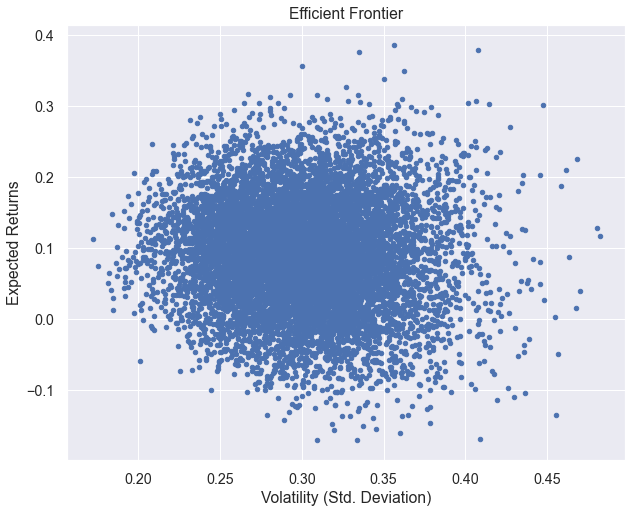

In [70]:
# plot the efficient frontier with a scatter plot
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [71]:
# สร้างตัวแปรรอรับค่าจากการคำนวนรอไว้ก่อน
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# ตั้งค่าจำนวนการผสมพอร์ตการลงทุนที่ต้องการ
num_assets = len(assets)
num_portfolios = 5000

# การคำนวณตัวแปรเพื่อใช้ในการผสมสัดส่วนพอร์ตการลงทุน
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# Set random seed เพื่อให้ได้ผลลัพธ์เช่นเดิม
np.random.seed(19)

In [72]:
# สร้างผลตอบแทนของพอร์ตจาก returns และ Volatility 
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# กำหนดน้ำหนักพอร์ตการลงทุนแต่ละสินทรัพย์ให้อยู่ในตัวแปร portfolio
for counter,symbol in enumerate(assets):  
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# ตั้งค่าตัวแปร df เพื่อให้รับค่า portfolio ให้สามารถอ่านได้ง่ายขึ้นในรูปแบบ DataFrame
df = pd.DataFrame(portfolio)

In [73]:
df.head()

,Returns,Volatility,Sharpe Ratio,vt Weight,ixj Weight,igf Weight,reet Weight,TSLA Weight,002594.SZ Weight,XPEV Weight,AML.L Weight,0175.HK Weight
0,0.156644,0.322916,0.485094,0.110802,0.125642,0.040889,0.169334,0.186091,0.096798,0.176713,0.067131,0.026602
1,0.144447,0.325960,0.443145,0.193117,0.035648,0.176345,0.051345,0.133163,0.129439,0.193069,0.086922,0.000952
2,0.098557,0.323629,0.304538,0.107023,0.067079,0.189151,0.087527,0.049870,0.167643,0.194940,0.135912,0.000854
3,0.031626,0.352840,0.089631,0.078342,0.020666,0.069035,0.200154,0.115973,0.074250,0.190695,0.168141,0.082744
4,0.137560,0.291891,0.471273,0.042395,0.104449,0.046752,0.156155,0.147873,0.170741,0.029418,0.106861,0.195357


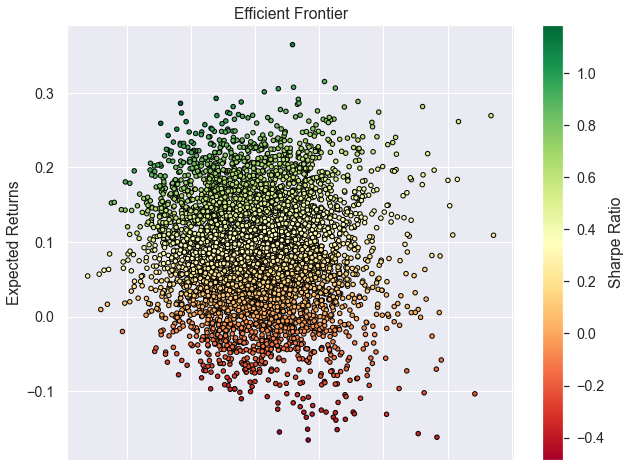

In [74]:
# จัดเรียงลำดับชื่อคอลัมน์เพื่อความสะดวกในการอ่านค่า
columns = ['Sharpe Ratio', 'Returns', 'Volatility', ] + [stock+' Weight' for stock in assets]

# กำหนดตัวแปร df ให้เรียงคอลัมน์ตามกำหนด
df = df[columns]

# plot frontier, max sharpe & min Volatility values with a scatterplot
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

# Find min volatility and max Sharpe ratio from dataframe

In [75]:
# กำหนดตัวแปรผลลัพธ์ที่ต้องการ
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_returns = df['Returns'].max()

In [76]:
min_volatility

0.1690434239769297

In [77]:
max_sharpe

1.1835700176609114

In [78]:
max_returns

0.3643897245714025

In [79]:
# กำหนดพอร์ตที่ต้องการแสดงผลบน Efficient frontier
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_return_port = df.loc[df['Returns'] == max_returns]

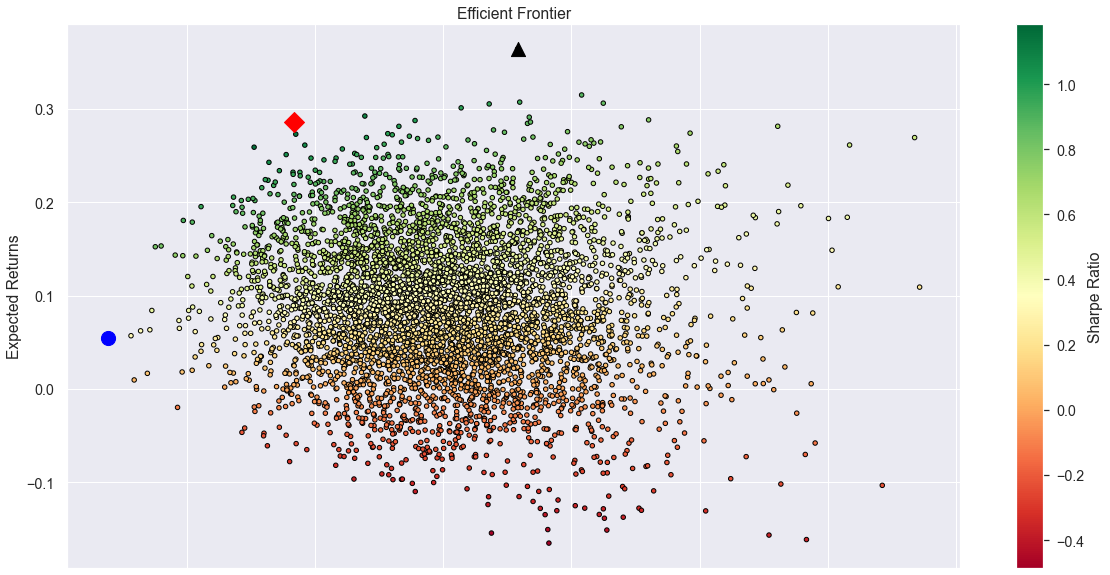

In [80]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(20, 10), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='o', s=200 )
plt.scatter(x=max_return_port['Volatility'], y=max_return_port['Returns'], c='black', marker='^', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

สามารถสร้างพอร์ตการลงทุนได้ 3 รูปแบบ
1. min_variance_port : เป็นพอร์ตที่ให้ความผันผวนต่ำ สามารถคาดหวังผลตอบแทนได้ที่ 10.46% ต่อปี
2. max_return_port : เป็นพอร์ตที่เน้นสร้างผลตอบแทน สามารถคาดหวังผลตอบแทนได้ที่ 37.10% ต่อปี
3. sharpe_portfolio : เป็นพอร์ตที่มีผลตอบแทนเทียบกับความเสี่ยงดีที่สุด สามารถคาดหวังผลตอบแทนได้ที่ 28.99% ต่อปี

โดยทั้ง 3 พอร์ตมีสัดส่วนการลงทุนในสินทรัพย์ประเภทต่างๆ ดังนี้

In [81]:
sharpe_portfolio

,Sharpe Ratio,Returns,Volatility,vt Weight,ixj Weight,igf Weight,reet Weight,TSLA Weight,002594.SZ Weight,XPEV Weight,AML.L Weight,0175.HK Weight
4076,1.18357,0.285886,0.241545,0.030155,0.002212,0.232472,0.254082,0.161255,0.257947,0.010059,0.017902,0.033916


In [82]:
min_variance_port

,Sharpe Ratio,Returns,Volatility,vt Weight,ixj Weight,igf Weight,reet Weight,TSLA Weight,002594.SZ Weight,XPEV Weight,AML.L Weight,0175.HK Weight
3374,0.322313,0.054485,0.169043,0.261795,0.305165,0.037791,0.302685,0.00656,0.026263,0.04878,0.006076,0.004885


In [83]:
max_return_port

,Sharpe Ratio,Returns,Volatility,vt Weight,ixj Weight,igf Weight,reet Weight,TSLA Weight,002594.SZ Weight,XPEV Weight,AML.L Weight,0175.HK Weight
4031,1.107688,0.36439,0.328964,0.050644,0.081667,0.167706,0.01939,0.366584,0.231807,0.029967,0.017298,0.034938


In [84]:
# concat 3 portfolio return and plot bar chart horizontal with plotly
fig = go.Figure(data=[
    go.Bar(name='Minimum Volatility', x=min_variance_port.T[1:2].index, y=min_variance_port.T[1:2].values[0]*100),
    go.Bar(name='Maximum Sharpe Ratio', x=sharpe_portfolio.T[1:2].index, y=sharpe_portfolio.T[1:2].values[0]*100),
    go.Bar(name='Maximum Return', x=max_return_port.T[1:2].index, y=max_return_port.T[1:2].values[0]*100)
])
# Change the bar mode
fig.update_layout(barmode='group')

# add title
fig.update_layout(title_text='Portfolio Return')

# add yaxis title
fig.update_yaxes(title_text='Return (%)')


fig.show()



In [85]:
portt = pd.concat([min_variance_port.T[3:], sharpe_portfolio.T[3:], max_return_port.T[3:]], axis=1)
portt.rename(columns={portt.columns[0]: 'Minimum Volatility', portt.columns[1]: 'Maximum Sharpe Ratio', portt.columns[2]: 'Maximum Return'}, inplace=True)
portt = (portt*100).round(2)

In [86]:
fig = go.Figure(data=[
    go.Bar(name='Minimum Volatility', x=portt.index, y=portt['Minimum Volatility']),
    go.Bar(name='Maximum Sharpe Ratio', x=portt.index, y=portt['Maximum Sharpe Ratio']),
    go.Bar(name='Maximum Return', x=portt.index, y=portt['Maximum Return']),
])
# Change the bar mode
fig.update_layout(barmode='group')

# add title
fig.update_layout(
    title={
        'text': "Portfolio weight of 3 portfolio",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# add yaxis title
fig.update_yaxes(title_text='Weight (%)')

fig.show()

